In [1]:
import pandas as pd
import numpy as np
import requests
import io
import matplotlib.pyplot as plt
import os
import re
from pathlib import Path

# Directory

In [2]:
meta_path = r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\AP\ap_VolFilt.csv"
sample_log_path = r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\LTER_sample_log.xlsx"

# CTD Data
CTD_TPL = r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\CTD\{cruise}\{cruise}_cast_{cast}.csv"
BOTTLE_TPL = r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\CTD\Bottle_Summary\{cruise}_ctd_bottle_summary.csv"
base_ctd_dir = r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\CTD"

#Bofu
bofu_data = r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\Depth\nes_lter_surface_features_winter_summer_v20250116_bofu_added_07282025.csv"

# Read in ap meta data

In [3]:
ap_meta = pd.read_csv(meta_path)

# rename depth to depth_log
if "depth" in ap_meta.columns:
    ap_meta = ap_meta.rename(columns={"depth": "depth_log"})

# normalize columns for merging
ap_meta["cruise"] = ap_meta["cruise"].astype(str).str.strip().str.lower()
ap_meta["cast"]   = pd.to_numeric(ap_meta["cast"], errors="coerce").astype("Int64")
ap_meta["niskin"] = pd.to_numeric(ap_meta["niskin"], errors="coerce").astype("Int64")

(ap_meta.head())

,cruise,cast,niskin,p_filename,d_filename,Ap_vol,station,depth_log,date_UTC,Lat,Lon
0,ae2426,1,2,AE2426_C01N02pa_RawData.txt,AE2426_C01N02da_RawData.txt,537,L1,17,20241106.0,41.19714,-70.88270
1,ae2426,1,2,AE2426_C01N02pa_RawData.txt,AE2426_C01N02da_RawData.txt,537,L1,17,20241106.0,41.19714,-70.88270
2,ae2426,1,2,AE2426_C01N02pa_RawData.txt,AE2426_C01N02da_RawData.txt,537,L1,17,20241106.0,41.19714,-70.88270
3,ae2426,1,13,AE2426_C01N13pa_RawData.txt,AE2426_C01N13da_RawData.txt,547,L1,3,20241106.0,41.19590,-70.88358
4,ae2426,1,13,AE2426_C01N13pa_RawData.txt,AE2426_C01N13da_RawData.txt,547,L1,3,20241106.0,41.19590,-70.88358


# Read in Sample Log

In [4]:
sample_log = pd.read_excel(sample_log_path, sheet_name="Sample_log")

# Normalize cruise and numeric fields
sample_log["Cruise"] = sample_log["Cruise"].astype(str).str.lower().str.strip()
sample_log["Cast"]   = pd.to_numeric(sample_log["Cast"], errors="coerce").astype("Int64")
sample_log["Niskin #"] = pd.to_numeric(sample_log["Niskin #"], errors="coerce").astype("Int64")

# Keep only rows with numeric Ap vol
sample_log = sample_log[pd.to_numeric(sample_log["Ap vol"], errors="coerce").notna()].copy()

In [5]:
# Keep only cruises that are in ap_meta
valid_cruises = ap_meta["cruise"].dropna().str.lower().unique()
sample_log = sample_log[sample_log["Cruise"].isin(valid_cruises)].copy()

print(f"{len(sample_log)} rows in sample log after filtering to cruises in ap_VolFilt.")
print(f"Cruises retained: {sorted(sample_log['Cruise'].unique())}")

339 rows in sample log after filtering to cruises in ap_VolFilt.
Cruises retained: ['ae2426', 'ar28b', 'ar61b', 'en608', 'en617', 'en661', 'en687', 'en695', 'en706', 'en712', 'en715', 'en720']


# Read in Bottle Metadata

In [6]:
def fetch_bottle_summary(cruise: str) -> pd.DataFrame:
    """
    Load CTD bottle summary for a given cruise from local CSV.
    Uses BOTTLE_TPL = ...\\{cruise}_ctd_bootle_summary.csv
    """
    cruise_norm = cruise.strip().lower()

    # Build local path
    bottle_path = Path(BOTTLE_TPL.format(cruise=cruise_norm))

    if not bottle_path.is_file():
        raise FileNotFoundError(f"No bottle summary CSV found for {cruise} at {bottle_path}")

    df = pd.read_csv(bottle_path)

    # store cruise in lowercase to match ap_meta / sample_log
    df["cruise"] = cruise_norm

    # normalize datatypes
    df["cast"]   = pd.to_numeric(df.get("cast"), errors="coerce")
    df["niskin"] = pd.to_numeric(df.get("niskin"), errors="coerce")

    # rename depth to depth_CTD if present
    if "depth" in df.columns:
        df = df.rename(columns={"depth": "depth_CTD"})

    return df


In [7]:
all_bottles = []

for cr in valid_cruises:
    try:
        bottles = fetch_bottle_summary(cr)
        bottles["cruise"] = bottles["cruise"].str.strip().str.lower()
        bottles["cast"]   = pd.to_numeric(bottles["cast"], errors="coerce").astype("Int64")
        bottles["niskin"] = pd.to_numeric(bottles["niskin"], errors="coerce").astype("Int64")

        if not bottles.empty:
            print(f"Fetched {len(bottles)} bottles for {cr}")
            all_bottles.append(bottles)
        else:
            print(f"No bottles returned for {cr}")
    except Exception as e:
        print(f"Skipping {cr}: could not fetch bottle summary ({e})")
        continue

# Combine all into one DataFrame
if all_bottles:
    all_bottles_df = pd.concat(all_bottles, ignore_index=True)
    print(f"\nFinal merged bottle summary: {all_bottles_df.shape[0]} rows across {len(valid_cruises)} valid_cruises")
else:
    print("No bottle summaries fetched.")


Fetched 265 bottles for ae2426
Fetched 167 bottles for ar28b
Fetched 296 bottles for ar61b
Fetched 336 bottles for en608
Fetched 358 bottles for en617
Fetched 255 bottles for en661
Fetched 318 bottles for en687
Fetched 267 bottles for en695
Fetched 302 bottles for en706
Fetched 278 bottles for en712
Fetched 336 bottles for en715
Fetched 301 bottles for en720

Final merged bottle summary: 3479 rows across 12 valid_cruises


In [8]:
all_bottles_df

,cruise,cast,niskin,date,latitude,longitude,depth_CTD
0,ae2426,1,1,2024-11-06 16:28:00+00:00,41.19725,-70.88264,16.808
1,ae2426,1,2,2024-11-06 16:28:29+00:00,41.19714,-70.88270,16.618
2,ae2426,1,3,2024-11-06 16:28:50+00:00,41.19703,-70.88274,16.557
3,ae2426,1,4,2024-11-06 16:29:06+00:00,41.19696,-70.88280,16.933
4,ae2426,1,5,2024-11-06 16:29:27+00:00,41.19686,-70.88287,17.108
...,...,...,...,...,...,...,...
3474,en720,24,5,2024-09-11 05:40:07+00:00,41.31785,-70.58162,8.536
3475,en720,24,6,2024-09-11 05:42:06+00:00,41.31774,-70.58241,3.450
3476,en720,24,7,2024-09-11 05:42:12+00:00,41.31774,-70.58245,3.356
3477,en720,24,8,2024-09-11 05:42:20+00:00,41.31774,-70.58248,3.582


In [9]:
# Merge with sample log to keep only bottles that have ap samples
if not all_bottles_df.empty:
    bottles_filtered = all_bottles_df.merge(
        sample_log.rename(columns={
            "Cruise": "cruise",
            "Cast": "cast",
            "Niskin #": "niskin"
        })[["cruise", "cast", "niskin"]],
        on=["cruise", "cast", "niskin"],
        how="inner"
    )

    print(f"\nFiltered to {len(bottles_filtered)} bottles with ap samples across {bottles_filtered['cruise'].nunique()} cruises.")
else:
    bottles_filtered = pd.DataFrame()
    print("No bottles to filter.")


Filtered to 337 bottles with ap samples across 12 cruises.


# Two Bottle Assignment

In [10]:
def assign_depth_zone(df):
    zones = []

    for (cr, ca), g in df.groupby(["cruise", "cast"]):
        g_sorted = g.sort_values("depth_CTD")
        labels = [None] * len(g_sorted)

        # Only assign labels if exactly two bottles
        if len(g_sorted) == 2:
            labels[0] = "Surface"
            labels[1] = "DCM"

        zones.append(pd.Series(labels, index=g_sorted.index))

    return pd.concat(zones).sort_index()

# Apply
bottles_filtered["depth_zone"] = assign_depth_zone(bottles_filtered)

if "depth_zone_method" not in bottles_filtered.columns:
    bottles_filtered["depth_zone_method"] = None

bottles_filtered[["cruise","cast","niskin","depth_CTD","depth_zone"]].sort_values(["cruise","cast","depth_CTD"]).head()

,cruise,cast,niskin,depth_CTD,depth_zone
1,ae2426,1,13,2.879,Surface
0,ae2426,1,2,16.618,DCM
4,ae2426,4,16,2.887,None
3,ae2426,4,10,14.765,None
2,ae2426,4,4,27.042,None


In [11]:
# Add a method label: 'two niskins' if a depth zone was successfully assigned, else None
bottles_filtered["depth_zone_method"] = bottles_filtered["depth_zone"].apply(
    lambda x: "two niskins" if pd.notna(x) else None
)
bottles_filtered.head()

,cruise,cast,niskin,date,latitude,longitude,depth_CTD,depth_zone,depth_zone_method
0,ae2426,1,2,2024-11-06 16:28:29+00:00,41.19714,-70.88270,16.618,DCM,two niskins
1,ae2426,1,13,2024-11-06 16:34:45+00:00,41.19590,-70.88358,2.879,Surface,two niskins
2,ae2426,4,4,2024-11-07 08:39:11+00:00,41.03141,-70.88173,27.042,None,None
3,ae2426,4,10,2024-11-07 08:42:05+00:00,41.03156,-70.88124,14.765,None,None
4,ae2426,4,16,2024-11-07 08:44:42+00:00,41.03166,-70.88078,2.887,None,None


# IFCB Assignment

# Three Bottle Assignment

In [11]:
# For casts with 3+ bottles, label the shallowest bottle as Surface (method = shallowest)
for (cr, ca), g in bottles_filtered.groupby(["cruise", "cast"]):
    if len(g) >= 3:
        shallow_idx = g["depth_CTD"].idxmin()
        bottles_filtered.loc[shallow_idx, "depth_zone"] = "Surface"
        bottles_filtered.loc[shallow_idx, "depth_zone_method"] = "shallowest"

print(bottles_filtered["depth_zone"].value_counts(dropna=False))
print(bottles_filtered["depth_zone_method"].value_counts(dropna=False))

depth_zone
Surface    136
None       129
DCM         72
Name: count, dtype: int64
depth_zone_method
two niskins    144
None           129
shallowest      64
Name: count, dtype: int64


In [12]:
# enforce Surface < 10 m rule
mask_invalid_surface = (bottles_filtered["depth_zone"] == "Surface") & (bottles_filtered["depth_CTD"] >= 7)

# Clear depth_zone and method for invalid Surface labels
bottles_filtered.loc[mask_invalid_surface, ["depth_zone", "depth_zone_method"]] = np.nan


In [13]:
df_nan = bottles_filtered[
    bottles_filtered["depth_zone"].isna() |
    (bottles_filtered["depth_zone_method"].astype(str).str.lower() == "shallowest")
].copy()


In [14]:
# Drop rows where depth_zone became NaN
bottles_filtered = bottles_filtered[
    bottles_filtered["depth_zone"].notna()
].copy()

# Restore clean title case for downstream consistency
bottles_filtered["depth_zone"] = bottles_filtered["depth_zone"].str.title()

In [15]:
bottles_filtered

,cruise,cast,niskin,date,latitude,longitude,depth_CTD,depth_zone,depth_zone_method
0,ae2426,1,2,2024-11-06 16:28:29+00:00,41.19714,-70.88270,16.618,Dcm,two niskins
1,ae2426,1,13,2024-11-06 16:34:45+00:00,41.19590,-70.88358,2.879,Surface,two niskins
4,ae2426,4,16,2024-11-07 08:44:42+00:00,41.03166,-70.88078,2.887,Surface,shallowest
5,ae2426,5,7,2024-11-07 13:17:20+00:00,40.51366,-70.88240,36.793,Dcm,two niskins
6,ae2426,5,13,2024-11-07 13:21:43+00:00,40.51402,-70.88210,3.651,Surface,two niskins
...,...,...,...,...,...,...,...,...,...
330,en720,19,10,2024-09-10 06:40:55+00:00,40.04328,-70.88498,39.577,Dcm,two niskins
331,en720,19,20,2024-09-10 06:48:04+00:00,40.04184,-70.88484,6.011,Surface,two niskins
332,en720,20,9,2024-09-10 20:47:02+00:00,40.86192,-70.88446,34.000,Dcm,two niskins
333,en720,20,20,2024-09-10 20:58:31+00:00,40.86141,-70.88282,3.939,Surface,two niskins


In [16]:
df_nan

,cruise,cast,niskin,date,latitude,longitude,depth_CTD,depth_zone,depth_zone_method
2,ae2426,4,4,2024-11-07 08:39:11+00:00,41.03141,-70.88173,27.042,None,None
3,ae2426,4,10,2024-11-07 08:42:05+00:00,41.03156,-70.88124,14.765,None,None
4,ae2426,4,16,2024-11-07 08:44:42+00:00,41.03166,-70.88078,2.887,Surface,shallowest
7,ae2426,10,8,2024-11-08 11:07:05+00:00,39.77000,-70.88741,57.095,None,None
8,ae2426,10,13,2024-11-08 11:10:32+00:00,39.76972,-70.88770,41.646,None,None
...,...,...,...,...,...,...,...,...,...
326,en720,15,11,2024-09-09 09:22:33+00:00,40.15014,-70.88410,24.635,None,None
327,en720,15,18,2024-09-09 09:28:35+00:00,40.14988,-70.88428,3.879,Surface,shallowest
334,en720,24,2,2024-09-11 05:38:01+00:00,41.31798,-70.58055,15.633,None,None
335,en720,24,4,2024-09-11 05:39:59+00:00,41.31786,-70.58156,8.467,None,None


In [17]:
#combined_df = combined_df.drop(columns=["depth_zone_light", "depth_zone_dup", "depth_zone"], errors="ignore")
bottles_filtered.to_csv(r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\Depth\two_bottles.csv", index=False)

# Assign Bofu

In [18]:
features = pd.read_csv(bofu_data)

# normalize datatypes
features["cruise"] = features["cruise"].astype(str).str.lower()
features["cast"]   = pd.to_numeric(features["cast"], errors="coerce").astype("Int64")

In [19]:
#merge
dcm_features = df_nan.merge(
    features[["cruise","cast","mld","Euphotic_depth", "chlorophyll_zmax"]],
    on=["cruise","cast"], how="left")

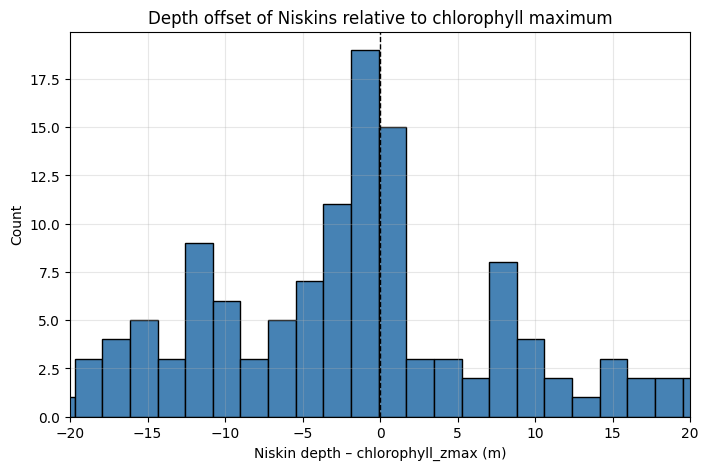

In [20]:
# Compute depth offset for all bottles with a chlorophyll_zmax value
dcm_features["offset_from_chlzmax"] = (
    dcm_features["depth_CTD"] - dcm_features["chlorophyll_zmax"])

plt.figure(figsize=(8, 5))
plt.hist(dcm_features["offset_from_chlzmax"].dropna(), bins=100, color="steelblue", edgecolor="black")
plt.axvline(0, color="k", linestyle="--", linewidth=1)
plt.xlabel("Niskin depth – chlorophyll_zmax (m)")
plt.ylabel("Count")
plt.title("Depth offset of Niskins relative to chlorophyll maximum")
plt.grid(alpha=0.3)
plt.xlim(-20, 20)
plt.show()


In [21]:
'''# Identify casts that already have both Surface and DCM
casts_with_both = (
    dcm_features
    .dropna(subset=["depth_zone"])
    .groupby(["cruise", "cast"])["depth_zone"]
    .apply(lambda x: {"Surface", "DCM"}.issubset(set(x)))
)

# casts_with_both: boolean Series (True = has both Surface & DCM)
casts_to_keep = casts_with_both[~casts_with_both].index   # False → incomplete casts
casts_to_drop = casts_with_both[casts_with_both].index     # True → fully classified casts

# Split into uncategorized and categorized
uncat = dcm_features.set_index(["cruise", "cast"]).loc[casts_to_keep].reset_index()
cat   = dcm_features.set_index(["cruise", "cast"]).loc[casts_to_drop].reset_index()

print(f"{len(uncat)} bottles in casts missing Surface or DCM (uncat)")
print(f"{len(cat)} bottles in fully classified casts (cat)")'''
uncat = df_nan

In [22]:
# Subset rows with no assigned depth_zone
#uncat = bottles_filtered[bottles_filtered["depth_zone"].isna()].copy()
#uncat = uncat.sort_values(["cruise","cast","depth_CTD"])

#print(f"Uncategorized niskins: {len(uncat)} out of {len(dcm_features)}")

In [23]:
def pick_dcm_bottle_uncat(df, tol=5):
    df = df.copy()
    
    # Ensure required columns exist
    if "depth_zone" not in df.columns:
        df["depth_zone"] = np.nan
    if "depth_zone_method" not in df.columns:
        df["depth_zone_method"] = None

    for (cr, ca), g in df.groupby(["cruise", "cast"]):
        # Skip if DCM or Surface already labeled in this cast
        if {"DCM", "Surface"}.issubset(set(g["depth_zone"].dropna())):
            continue

        dcm_depth = g["chlorophyll_zmax"].iloc[0]
        if pd.isna(dcm_depth):
            continue

        # Only look at unlabeled bottles
        g_uncat = g[g["depth_zone"].isna()].copy()
        if g_uncat.empty:
            continue

        # Find bottle within tolerance of chl zmax
        g_uncat["offset"] = (g_uncat["depth_CTD"] - dcm_depth).abs()
        in_tol = g_uncat[g_uncat["offset"] <= tol]

        if not in_tol.empty:
            chosen = in_tol.loc[in_tol["offset"].idxmin()]
            df.loc[chosen.name, "depth_zone"] = "DCM"
            df.loc[chosen.name, "depth_zone_method"] = "bofu tolerance"

    return df

# Apply
dcm_features_full = pick_dcm_bottle_uncat(dcm_features, tol=5)

In [24]:
# Check how many bottles were labeled
print("DCM count:", (dcm_features_full["depth_zone"] == "DCM").sum())
print(dcm_features_full["depth_zone_method"].value_counts(dropna=False))

DCM count: 42
depth_zone_method
None              88
shallowest        64
bofu tolerance    42
NaN                1
Name: count, dtype: int64


In [25]:
dcm_features_full

,cruise,cast,niskin,date,latitude,longitude,depth_CTD,depth_zone,depth_zone_method,mld,Euphotic_depth,chlorophyll_zmax,offset_from_chlzmax
0,ae2426,4,4,2024-11-07 08:39:11+00:00,41.03141,-70.88173,27.042,None,None,NaN,NaN,NaN,NaN
1,ae2426,4,10,2024-11-07 08:42:05+00:00,41.03156,-70.88124,14.765,None,None,NaN,NaN,NaN,NaN
2,ae2426,4,16,2024-11-07 08:44:42+00:00,41.03166,-70.88078,2.887,Surface,shallowest,NaN,NaN,NaN,NaN
3,ae2426,10,8,2024-11-08 11:07:05+00:00,39.77000,-70.88741,57.095,None,None,NaN,NaN,NaN,NaN
4,ae2426,10,13,2024-11-08 11:10:32+00:00,39.76972,-70.88770,41.646,None,None,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,en720,15,11,2024-09-09 09:22:33+00:00,40.15014,-70.88410,24.635,DCM,bofu tolerance,19.703697,NaN,27.0,-2.365
191,en720,15,18,2024-09-09 09:28:35+00:00,40.14988,-70.88428,3.879,Surface,shallowest,19.703697,NaN,27.0,-23.121
192,en720,24,2,2024-09-11 05:38:01+00:00,41.31798,-70.58055,15.633,None,None,10.098457,NaN,7.0,8.633
193,en720,24,4,2024-09-11 05:39:59+00:00,41.31786,-70.58156,8.467,DCM,bofu tolerance,10.098457,NaN,7.0,1.467


In [26]:
# Identify casts that already have both Surface and DCM 
casts_with_both = (
    dcm_features_full
    .dropna(subset=["depth_zone"])
    .groupby(["cruise", "cast"])["depth_zone"]
    .apply(lambda x: {"Surface", "DCM"}.issubset(set(x)))
)

# Keep only casts WITHOUT both Surface and DCM
casts_to_keep = casts_with_both[~casts_with_both].index  # where False

# This subset shows only casts that still need labeling
dcm_features_incomplete = (
    dcm_features_full
    .set_index(["cruise", "cast"])
    .loc[casts_to_keep]
    .reset_index()
)

print(f"Full dataset (with new DCMs): {len(dcm_features_full)} bottles")
print(f"Unresolved casts (missing Surface or DCM): {len(dcm_features_incomplete)} bottles")

Full dataset (with new DCMs): 195 bottles
Unresolved casts (missing Surface or DCM): 70 bottles


In [29]:
# Index of casts that already have both Surface and DCM
casts_with_both_idx = casts_with_both[casts_with_both].index

# All bottle rows for those casts
dcm_features_with_both = (
    dcm_features_full
    .set_index(["cruise", "cast"])
    .loc[casts_with_both_idx]
    .reset_index()
)

print(f"Casts with both Surface + DCM: {dcm_features_with_both[['cruise','cast']].drop_duplicates().shape[0]} casts")
print(f"Rows in dcm_features_with_both: {len(dcm_features_with_both)} bottles")


Casts with both Surface + DCM: 41 casts
Rows in dcm_features_with_both: 123 bottles


In [31]:
dcm_features_with_both = dcm_features_with_both.drop(
    columns=["mld", "Euphotic_depth", "chlorophyll_zmax", "offset_from_chlzmax"]
)


In [32]:
dcm_features_with_both

,cruise,cast,niskin,date,latitude,longitude,depth_CTD,depth_zone,depth_zone_method
0,en608,15,11,2018-02-02 19:17:58+00:00,40.12134,-70.80432,34.152,None,None
1,en608,15,15,2018-02-02 19:21:06+00:00,40.12068,-70.80541,14.387,DCM,bofu tolerance
2,en608,15,19,2018-02-02 19:23:19+00:00,40.12008,-70.80616,6.252,Surface,shallowest
3,en608,30,1,2018-02-05 00:07:32+00:00,41.32240,-70.57520,13.388,DCM,bofu tolerance
4,en608,30,5,2018-02-05 00:09:33+00:00,41.32224,-70.57470,10.248,None,None
...,...,...,...,...,...,...,...,...,...
118,en720,15,11,2024-09-09 09:22:33+00:00,40.15014,-70.88410,24.635,DCM,bofu tolerance
119,en720,15,18,2024-09-09 09:28:35+00:00,40.14988,-70.88428,3.879,Surface,shallowest
120,en720,24,2,2024-09-11 05:38:01+00:00,41.31798,-70.58055,15.633,None,None
121,en720,24,4,2024-09-11 05:39:59+00:00,41.31786,-70.58156,8.467,DCM,bofu tolerance


In [33]:
#combined_df = combined_df.drop(columns=["depth_zone_light", "depth_zone_dup", "depth_zone"], errors="ignore")
dcm_features_with_both.to_csv(r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\Depth\bofu_bottles.csv", index=False)

In [27]:
dcm_features_incomplete

,cruise,cast,niskin,date,latitude,longitude,depth_CTD,depth_zone,depth_zone_method,mld,Euphotic_depth,chlorophyll_zmax,offset_from_chlzmax
0,ae2426,4,4,2024-11-07 08:39:11+00:00,41.03141,-70.88173,27.042,None,None,NaN,NaN,NaN,NaN
1,ae2426,4,10,2024-11-07 08:42:05+00:00,41.03156,-70.88124,14.765,None,None,NaN,NaN,NaN,NaN
2,ae2426,4,16,2024-11-07 08:44:42+00:00,41.03166,-70.88078,2.887,Surface,shallowest,NaN,NaN,NaN,NaN
3,ae2426,10,8,2024-11-08 11:07:05+00:00,39.77000,-70.88741,57.095,None,None,NaN,NaN,NaN,NaN
4,ae2426,10,13,2024-11-08 11:10:32+00:00,39.76972,-70.88770,41.646,None,None,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,en715,5,13,2024-05-04 11:02:28+00:00,40.69576,-70.88342,10.070,None,None,30.716983,NaN,3.0,7.070
66,en715,5,18,2024-05-04 11:04:28+00:00,40.69561,-70.88356,3.093,Surface,shallowest,30.716983,NaN,3.0,0.093
67,en720,8,6,2024-09-08 05:37:22+00:00,39.94080,-70.89176,72.922,None,None,NaN,NaN,59.0,13.922
68,en720,8,9,2024-09-08 05:40:58+00:00,39.94104,-70.89284,53.215,None,None,NaN,NaN,59.0,-5.785


# Get light profile

In [34]:
ctd_files = []

file_pat = re.compile(r"([A-Za-z0-9]+)_cast_(\d+)\.csv$", re.IGNORECASE)

for cruise_dir in sorted(os.listdir(base_ctd_dir)):
    cruise_path = os.path.join(base_ctd_dir, cruise_dir)

    # Only look at directories (cruise folders)
    if not os.path.isdir(cruise_path):
        continue

    for fname in os.listdir(cruise_path):
        m = file_pat.match(fname)
        if m:
            cruise_in_name, cast = m.groups()

            # Use the folder name as the true cruise ID
            cruise = cruise_dir.strip().lower()

            ctd_files.append({
                "cruise": cruise,
                "cast": int(cast),
                "path": os.path.join(cruise_path, fname)
            })

print(f"Found {len(ctd_files)} CTD profiles across all cruises.")

Found 283 CTD profiles across all cruises.


In [35]:
def get_light_at_depth(ctd_df, target_depth):
    """Return PAR value nearest to target_depth."""
    if pd.isna(target_depth):
        return np.nan
    valid = ctd_df.dropna(subset=["depsm", "par"])
    if valid.empty:
        return np.nan
    idx = (valid["depsm"] - target_depth).abs().idxmin()
    return valid.loc[idx, "par"]

In [36]:
records = []

for f in ctd_files:
    cruise, cast, path = f["cruise"], f["cast"], f["path"]

    subset = dcm_features_incomplete[
        (dcm_features_incomplete["cruise"].str.contains(cruise, case=False, na=False))
        & (dcm_features_incomplete["cast"] == cast)
    ]
    if subset.empty:
        continue

    try:
        ctd = pd.read_csv(path)
    except Exception as e:
        print(f"Could not read {path}: {e}")
        continue

    # --- Ensure numeric ---
    for col in ["depsm", "par"]:
        if col in ctd.columns:
            ctd[col] = pd.to_numeric(ctd[col], errors="coerce")

    if "depsm" not in ctd.columns or "par" not in ctd.columns:
        continue

    # --- Smooth PAR to reduce spikes ---
    # rolling median preserves structure but removes noise
    ctd = ctd.sort_values("depsm")
    ctd["par_smooth"] = (
        ctd["par"].rolling(window=7, center=True, min_periods=1).median()
    )

    # Optional alternative: smoother (comment/uncomment as desired)
    # from scipy.signal import savgol_filter
    # ctd["par_smooth"] = savgol_filter(ctd["par"].interpolate(limit_direction="both"), 11, 2)

    # --- Use smoothed PAR for reference and interpolation ---
    par_surface = ctd["par_smooth"].max(skipna=True)
    if np.isnan(par_surface) or par_surface <= 0:
        continue

    def get_light_at_depth(ctd_df, target_depth):
        """Return smoothed PAR value nearest to target_depth."""
        if pd.isna(target_depth):
            return np.nan
        valid = ctd_df.dropna(subset=["depsm", "par_smooth"])
        if valid.empty:
            return np.nan
        idx = (valid["depsm"] - target_depth).abs().idxmin()
        return valid.loc[idx, "par_smooth"]

    # --- Compute % light at each bottle depth ---
    for _, row in subset.iterrows():
        depth = row.get("depth_CTD", np.nan)
        par_val = get_light_at_depth(ctd, depth)
        pct_surface = (par_val / par_surface * 100) if par_surface > 0 else np.nan

        records.append({
            "cruise": cruise,
            "cast": cast,
            "niskin": row.get("niskin"),
            "depth_CTD": depth,
            "depth_zone": row.get("depth_zone"),
            "depth_zone_method": row.get("depth_zone_method"),
            "PAR_nearest": par_val,
            "PAR_surface": par_surface,
            "Percent_surface_light": pct_surface
        })

print(f"Matched {len(records)} Niskins across all CTD files (using smoothed PAR).")


Matched 58 Niskins across all CTD files (using smoothed PAR).


In [38]:
dcm_features_incomplete

,cruise,cast,niskin,date,latitude,longitude,depth_CTD,depth_zone,depth_zone_method,mld,Euphotic_depth,chlorophyll_zmax,offset_from_chlzmax
0,ae2426,4,4,2024-11-07 08:39:11+00:00,41.03141,-70.88173,27.042,None,None,NaN,NaN,NaN,NaN
1,ae2426,4,10,2024-11-07 08:42:05+00:00,41.03156,-70.88124,14.765,None,None,NaN,NaN,NaN,NaN
2,ae2426,4,16,2024-11-07 08:44:42+00:00,41.03166,-70.88078,2.887,Surface,shallowest,NaN,NaN,NaN,NaN
3,ae2426,10,8,2024-11-08 11:07:05+00:00,39.77000,-70.88741,57.095,None,None,NaN,NaN,NaN,NaN
4,ae2426,10,13,2024-11-08 11:10:32+00:00,39.76972,-70.88770,41.646,None,None,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,en715,5,13,2024-05-04 11:02:28+00:00,40.69576,-70.88342,10.070,None,None,30.716983,NaN,3.0,7.070
66,en715,5,18,2024-05-04 11:04:28+00:00,40.69561,-70.88356,3.093,Surface,shallowest,30.716983,NaN,3.0,0.093
67,en720,8,6,2024-09-08 05:37:22+00:00,39.94080,-70.89176,72.922,None,None,NaN,NaN,59.0,13.922
68,en720,8,9,2024-09-08 05:40:58+00:00,39.94104,-70.89284,53.215,None,None,NaN,NaN,59.0,-5.785


In [37]:
light_df = pd.DataFrame(records)
light_df.head(10)

,cruise,cast,niskin,depth_CTD,depth_zone,depth_zone_method,PAR_nearest,PAR_surface,Percent_surface_light
0,ae2426,10,8,57.095,None,None,0.093984,4.582300,2.051022
1,ae2426,10,13,41.646,None,None,0.240060,4.582300,5.238854
2,ae2426,10,19,2.797,Surface,shallowest,4.014000,4.582300,87.597931
3,ae2426,11,6,52.983,None,None,6.615200,604.165000,1.094933
4,ae2426,11,11,30.848,None,None,43.291000,604.165000,7.165427
5,ae2426,11,21,3.145,Surface,shallowest,578.760000,604.165000,95.795023
6,ae2426,16,6,65.109,None,None,0.073934,0.940595,7.860344
7,ae2426,16,13,19.973,None,None,0.073934,0.940595,7.860344
8,ae2426,16,19,3.325,Surface,shallowest,0.704590,0.940595,74.908967
9,ae2426,17,4,52.422,None,None,0.009090,0.956130,0.950760


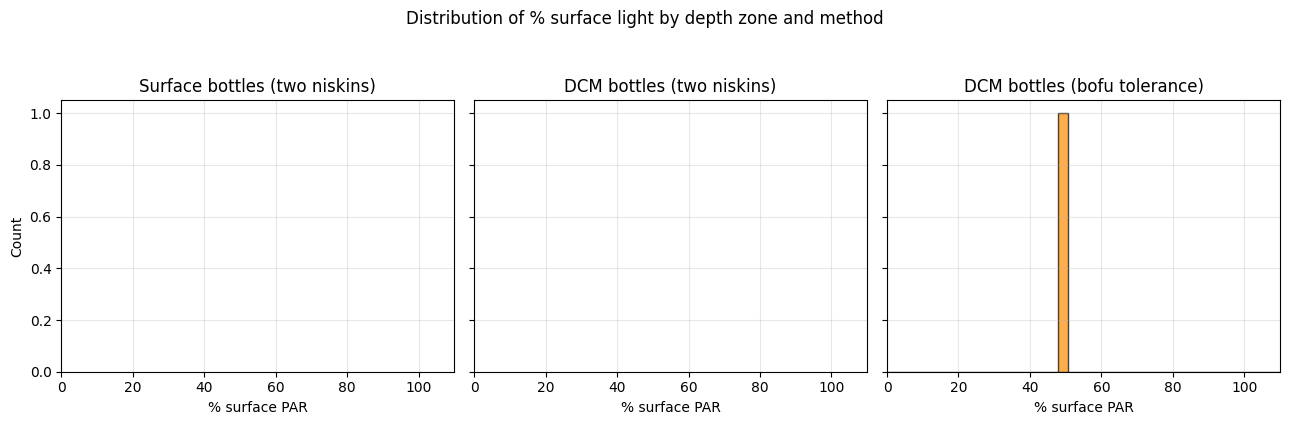

In [39]:
def plot_light_distributions_threepanel(df):
    """
    Three-panel figure of % surface light distributions:
      [1] Surface bottles — two niskins
      [2] DCM bottles — two niskins
      [3] DCM bottles — bofu tolerance
    """
    bins = np.linspace(0, 110, 40)
    colors = {"two niskins": "steelblue", "bofu tolerance": "darkorange", None: "gray"}

    fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)

    # --- Panel 1: Surface (two niskins)
    sub_surface = df[(df["depth_zone"] == "Surface") & (df["depth_zone_method"] == "two niskins")]
    if not sub_surface.empty:
        axes[0].hist(
            sub_surface["Percent_surface_light"].dropna(),
            bins=bins, color=colors["two niskins"], alpha=0.7, edgecolor="black"
        )
    axes[0].set_title("Surface bottles (two niskins)")
    axes[0].set_xlabel("% surface PAR")
    axes[0].set_ylabel("Count")
    axes[0].set_xlim(0, 110)
    axes[0].grid(alpha=0.3)

    # --- Panel 2: DCM (two niskins)
    sub_dcm_two = df[(df["depth_zone"] == "DCM") & (df["depth_zone_method"] == "two niskins")]
    if not sub_dcm_two.empty:
        axes[1].hist(
            sub_dcm_two["Percent_surface_light"].dropna(),
            bins=bins, color=colors["two niskins"], alpha=0.7, edgecolor="black"
        )
    axes[1].set_title("DCM bottles (two niskins)")
    axes[1].set_xlabel("% surface PAR")
    axes[1].set_xlim(0, 110)
    axes[1].grid(alpha=0.3)

    # --- Panel 3: DCM (bofu tolerance)
    sub_dcm_bofu = df[(df["depth_zone"] == "DCM") & (df["depth_zone_method"] == "bofu tolerance")]
    if not sub_dcm_bofu.empty:
        axes[2].hist(
            sub_dcm_bofu["Percent_surface_light"].dropna(),
            bins=bins, color=colors["bofu tolerance"], alpha=0.7, edgecolor="black"
        )
    axes[2].set_title("DCM bottles (bofu tolerance)")
    axes[2].set_xlabel("% surface PAR")
    axes[2].set_xlim(0, 110)
    axes[2].grid(alpha=0.3)

    plt.suptitle("Distribution of % surface light by depth zone and method", y=1.05)
    plt.tight_layout()
    plt.show()

df = light_df.copy()
plot_light_distributions_threepanel(light_df)

## Categorize niskins by light  

In [40]:
def classify_by_light(row):
    pct = row["Percent_surface_light"]
    zone = str(row["depth_zone"]).lower()
    
    if zone == "surface":
        return "Surface"
    elif pd.isna(pct):
        return None
    elif 90 <= pct <= 100:
        return "Surface_light"
    elif -1 <= pct <= 10:
        return "DCM_light"
    else:
        return None

light_df["depth_zone_light"] = light_df.apply(classify_by_light, axis=1)


In [41]:
# --- Step 1: Filter to only Surface / Surface_light entries ---
mask_surface_like = light_df["depth_zone_light"].isin(["Surface", "Surface_light"])
surf_like = light_df[mask_surface_like].copy()

# --- Step 2: Find shallowest (minimum depth) per (cruise, cast) ---
idx_keep = (
    surf_like.groupby(["cruise", "cast"])["depth_CTD"]
    .idxmin()  # index of shallowest bottle per cast
)

# --- Step 3: Set non-shallowest Surface/Surface_light to None ---
light_df.loc[mask_surface_like & ~light_df.index.isin(idx_keep), "depth_zone_light"] = None

# --- Optional summary ---
duplicates_removed = len(surf_like) - len(idx_keep)
print(f"Set {duplicates_removed} non-shallowest 'Surface'/'Surface_light' bottles to None.")


Set 2 non-shallowest 'Surface'/'Surface_light' bottles to None.


19 bottles labeled Surface or Surface_light by light-based classification.
19 bottles labeled Surface by depth-based classification only.


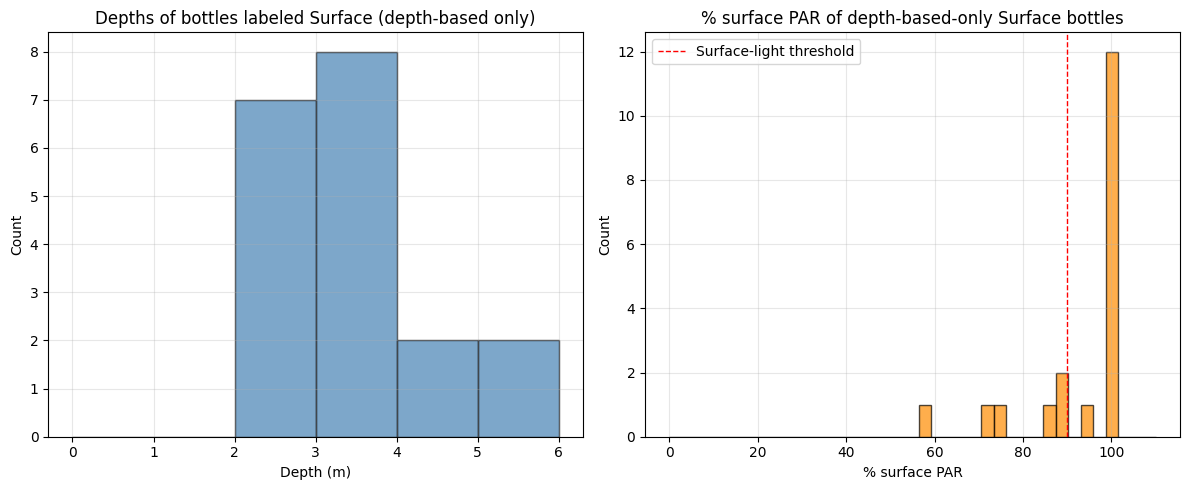

In [42]:
# Subset: Surface by depth, not by light
subset = light_df[light_df["depth_zone_light"].isin(["Surface", "Surface_light"])].copy()
print(f"{len(subset)} bottles labeled Surface or Surface_light by light-based classification.")


print(f"{len(subset)} bottles labeled Surface by depth-based classification only.")

# Define bins
depth_bins = np.arange(0, subset["depth_CTD"].max() + 1, 1)
par_bins   = np.linspace(0, 110, 40)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: Depth histogram ---
axes[0].hist(
    subset["depth_CTD"].dropna(),
    bins=depth_bins,
    color="steelblue",
    edgecolor="black",
    alpha=0.7
)
axes[0].set_xlabel("Depth (m)")
axes[0].set_ylabel("Count")
axes[0].set_title("Depths of bottles labeled Surface (depth-based only)")
axes[0].grid(alpha=0.3)

# --- Right: % surface PAR histogram ---
axes[1].hist(
    subset["Percent_surface_light"].dropna(),
    bins=par_bins,
    color="darkorange",
    edgecolor="black",
    alpha=0.7
)
axes[1].set_xlabel("% surface PAR")
axes[1].set_ylabel("Count")
axes[1].set_title("% surface PAR of depth-based-only Surface bottles")
axes[1].grid(alpha=0.3)
axes[1].axvline(90, color="red", linestyle="--", lw=1, label="Surface-light threshold")
axes[1].legend()

plt.tight_layout()
plt.show()


In [43]:
# --- Find Surface bottles deeper than 7 m ---
deep_surface = subset[subset["Percent_surface_light"] <90]

print(f"{len(deep_surface)} 'Surface' bottles deeper than 90 %:\n")
print(deep_surface[["cruise", "cast", "niskin", "depth_CTD", "Percent_surface_light"]].sort_values(["cruise", "cast", "niskin"]))

6 'Surface' bottles deeper than 90 %:

    cruise  cast  niskin  depth_CTD  Percent_surface_light
20  ae2426     4      16      2.887              86.701685
2   ae2426    10      19      2.797              87.597931
8   ae2426    16      19      3.325              74.908967
11  ae2426    17      18      2.732              72.140818
30   en661     7      18      4.399              58.539496
39   en695     6      19      5.572              89.180609


6 questionable 'surface' bottles (<90% surface light).
3 cruises have at least one questionable cast.

Plotting ae2426 (casts: [np.int64(10), np.int64(16), np.int64(17), np.int64(4)])

Plotting en661 (casts: [np.int64(7)])

Plotting en695 (casts: [np.int64(6)])


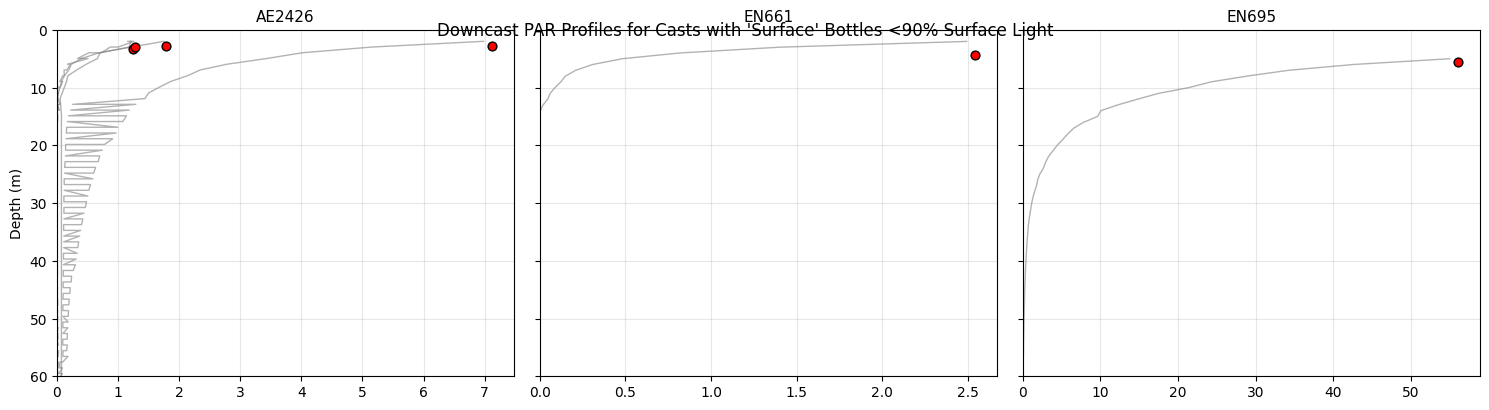

In [44]:
# --- 1. Filter questionable surface bottles (<90% surface light) ---
questionable_surface = light_df[
    light_df["depth_zone_light"].isin(["Surface", "Surface_light"])
    & (light_df["Percent_surface_light"] < 90)
].copy()

print(f"{len(questionable_surface)} questionable 'surface' bottles (<90% surface light).")

# --- 2. Identify cruises with questionable casts ---
cruise_groups = (
    questionable_surface.groupby("cruise")["cast"]
    .unique()
    .to_dict()
)
print(f"{len(cruise_groups)} cruises have at least one questionable cast.")

# --- 3. User-set vertical limit (in meters) ---
ylim = (0, 60)   # adjust as needed, e.g., (0, 40) or (0, 100)

# --- 4. Make 3×3 grid of subplots ---
n_cruises = len(cruise_groups)
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 12), sharey=True)
axes = axes.flatten()

# --- 5. Loop through cruises and plot ---
for i, (cruise, casts) in enumerate(cruise_groups.items()):
    if i >= nrows * ncols:
        break  # limit to 9 panels

    ax = axes[i]
    print(f"\nPlotting {cruise} (casts: {list(casts)})")

    for cast in casts:
        # Find CTD file
        match = next(
            (m for m in ctd_files
             if m["cruise"].lower() == cruise.lower()
             and m["cast"] == cast),
            None
        )
        if match is None:
            print(f"  ⚠️ No CTD file for {cruise} cast {cast}")
            continue

        # Load CTD
        df = pd.read_csv(match["path"])
        par_col = next((c for c in ["par", "cpar", "spar"] if c in df.columns), None)
        depth_col = "depsm"
        if par_col is None or depth_col not in df.columns:
            continue

        # Downcast only
        df = df.dropna(subset=[par_col, depth_col]).sort_values(by=depth_col)
        depth_diff = np.gradient(df[depth_col])
        df_down = df[depth_diff > 0].copy()

        # Plot downcast line
        ax.plot(df_down[par_col], df_down[depth_col],
                lw=1, alpha=0.6, color="gray")

        # Overlay questionable bottles for this cast
        qs_sub = questionable_surface[
            (questionable_surface["cruise"].str.lower() == cruise.lower())
            & (questionable_surface["cast"] == cast)
        ]
        if not qs_sub.empty:
            ax.scatter(
                [df_down[par_col].max() * 1.02] * len(qs_sub),
                qs_sub["depth_CTD"],
                color="red", edgecolor="k", s=40, zorder=5
            )

    ax.set_title(cruise.upper(), fontsize=11)
    ax.invert_yaxis()
    ax.grid(alpha=0.3)
    ax.set_xlim(left=0)
    ax.set_ylim(ylim)
    ax.invert_yaxis()
    if i % ncols == 0:
        ax.set_ylabel("Depth (m)")
    if i >= (nrows - 1) * ncols:
        ax.set_xlabel("PAR (µmol photons m⁻² s⁻¹)")

# --- 6. Remove unused panels ---
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes[j])

# --- 7. Final layout ---
fig.suptitle("Downcast PAR Profiles for Casts with 'Surface' Bottles <90% Surface Light", y=0.95)
plt.tight_layout()
plt.show()


## Target cruise and cast and plot par profile w niskins

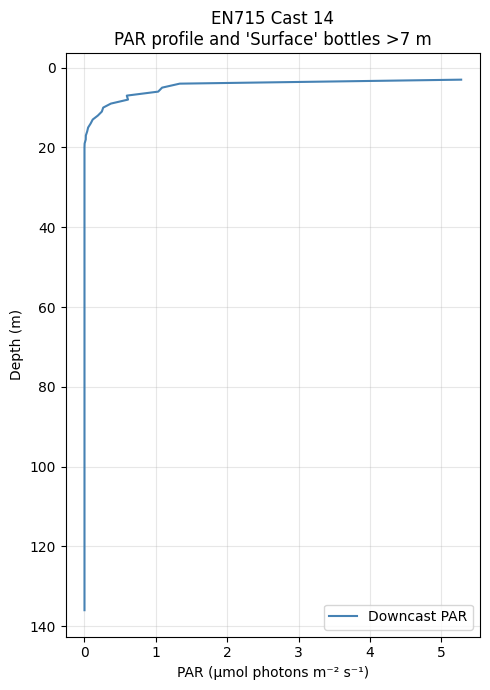

In [45]:
# --- User input ---
target_cruise = "EN715"
target_cast   = 14

# --- Find matching CTD file ---
match = next(
    (m for m in ctd_files
     if m["cruise"].lower() == target_cruise.lower()
     and m["cast"] == target_cast),
    None
)

if match is None:
    print(f"No CTD file found for {target_cruise} cast {target_cast}")
else:
    # --- Load CTD ---
    df = pd.read_csv(match["path"])
    par_col = next((c for c in ["par", "cpar", "spar"] if c in df.columns), None)
    depth_col = "depsm"

    df = df.dropna(subset=[par_col, depth_col]).sort_values(by=depth_col).reset_index(drop=True)

    # --- Extract downcast ---
    depth_diff = np.gradient(df[depth_col])
    df_down = df[depth_diff > 0].copy()

    # --- Filter deep "surface" bottles for this cruise + cast ---
    deep_sub = deep_surface[
        (deep_surface["cruise"].str.lower() == target_cruise.lower())
        & (deep_surface["cast"] == target_cast)
    ].copy()

    # --- Plot ---
    plt.figure(figsize=(5,7))
    plt.plot(df_down[par_col], df_down[depth_col], color="steelblue", lw=1.5, label="Downcast PAR")

    if not deep_sub.empty:
        plt.scatter(
            [df_down[par_col].max() * 1.02] * len(deep_sub),
            deep_sub["depth_CTD"],
            color="red",
            edgecolor="k",
            zorder=5,
            label="'Percent_surface_light <90 %"
        )
        for _, row in deep_sub.iterrows():
            plt.text(
                df_down[par_col].max() * 1.05,
                row["depth_CTD"],
                f"N{int(row['niskin'])}",
                va="center",
                ha="left",
                fontsize=8
            )

    # --- Format plot ---
    plt.gca().invert_yaxis()
    plt.xlabel(f"{par_col.upper()} (µmol photons m⁻² s⁻¹)")
    plt.ylabel("Depth (m)")
    plt.title(f"{target_cruise.upper()} Cast {target_cast}\nPAR profile and 'Surface' bottles >7 m")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Depth and light categories

In [46]:
# Start from light-based labels
light_df["depth_zone_dup"] = light_df["depth_zone_light"]

# Per-cast flags
n_dcm = (light_df["depth_zone_light"].eq("DCM_light")).groupby([light_df["cruise"], light_df["cast"]]).transform("sum")
has_dcm = light_df["depth_zone"].str.lower().eq("dcm").groupby([light_df["cruise"], light_df["cast"]]).transform("any")
has_none = light_df["depth_zone"].fillna("None").str.lower().eq("none").groupby([light_df["cruise"], light_df["cast"]]).transform("any")
target_cast = (n_dcm >= 2) & has_dcm & has_none

# Keep the true DCM, clear the other
light_df.loc[target_cast & light_df["depth_zone_light"].eq("DCM_light") & light_df["depth_zone"].str.lower().eq("dcm"), "depth_zone_dup"] = "DCM"
light_df.loc[target_cast & light_df["depth_zone_light"].eq("DCM_light") & ~light_df["depth_zone"].str.lower().eq("dcm"), "depth_zone_dup"] = None


In [47]:
mask = light_df["depth_zone"].str.lower().eq("dcm") & light_df["depth_zone_dup"].isna()
light_df.loc[mask, "depth_zone_dup"] = "DCM"


In [48]:
# --- Group by cast and count assignments ---
zone_counts = (
    light_df.groupby(["cruise", "cast", "depth_zone_dup"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Ensure expected columns exist
for col in ["Surface_light", "DCM_light", "DCM"]:
    if col not in zone_counts.columns:
        zone_counts[col] = 0

# --- Identify ambiguous (2+ DCMs) or missing (no Surface/DCM) casts ---
dup_condition = (zone_counts["DCM_light"] > 1)
missing_condition = (
    (zone_counts["Surface_light"] == 0)
    & (zone_counts["DCM_light"] == 0)
    & (zone_counts["DCM"] == 0)
)

# --- Combine conditions ---
dup_casts = zone_counts[dup_condition | missing_condition][["cruise", "cast"]]

# --- Subset full dataframe ---
dup_df = light_df[light_df.set_index(["cruise", "cast"]).index.isin(dup_casts.set_index(["cruise", "cast"]).index)].copy()
dup_df = dup_df.sort_values(["cruise", "cast"])

print(f"{len(dup_df['cast'].unique())} casts have duplicate DCMs or missing Surface/DCM assignments.")


12 casts have duplicate DCMs or missing Surface/DCM assignments.


In [49]:
dup_df

,cruise,cast,niskin,depth_CTD,depth_zone,depth_zone_method,PAR_nearest,PAR_surface,Percent_surface_light,depth_zone_light,depth_zone_dup
18,ae2426,4,4,27.042,None,None,1.000000e-12,1.080400e+00,9.255831e-11,DCM_light,DCM_light
19,ae2426,4,10,14.765,None,None,1.324800e-02,1.080400e+00,1.226213e+00,DCM_light,DCM_light
20,ae2426,4,16,2.887,Surface,shallowest,9.367250e-01,1.080400e+00,8.670168e+01,Surface,Surface
0,ae2426,10,8,57.095,None,None,9.398400e-02,4.582300e+00,2.051022e+00,DCM_light,DCM_light
1,ae2426,10,13,41.646,None,None,2.400600e-01,4.582300e+00,5.238854e+00,DCM_light,DCM_light
2,ae2426,10,19,2.797,Surface,shallowest,4.014000e+00,4.582300e+00,8.759793e+01,Surface,Surface
3,ae2426,11,6,52.983,None,None,6.615200e+00,6.041650e+02,1.094933e+00,DCM_light,DCM_light
4,ae2426,11,11,30.848,None,None,4.329100e+01,6.041650e+02,7.165427e+00,DCM_light,DCM_light
5,ae2426,11,21,3.145,Surface,shallowest,5.787600e+02,6.041650e+02,9.579502e+01,Surface,Surface
6,ae2426,16,6,65.109,None,None,7.393400e-02,9.405950e-01,7.860344e+00,DCM_light,DCM_light


In [50]:
# --- Identify clean (non-duplicate) casts ---
dup_cast_ids = dup_df[["cruise", "cast"]].drop_duplicates()
is_dup = light_df.set_index(["cruise", "cast"]).index.isin(dup_cast_ids.set_index(["cruise", "cast"]).index)
clean_df = light_df[~is_dup].copy()

# For casts that have both DCM and DCM_light, remove the DCM_light entry
mask_has_both = (
    clean_df.groupby(["cruise", "cast"])["depth_zone_dup"]
    .transform(lambda x: ("DCM" in x.values) and ("DCM_light" in x.values))
)
clean_df.loc[mask_has_both & (clean_df["depth_zone_dup"] == "DCM_light"), "depth_zone_dup"] = None


In [52]:
#combined_df = combined_df.drop(columns=["depth_zone_light", "depth_zone_dup", "depth_zone"], errors="ignore")
clean_df.to_csv(r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\Depth\light_bottles.csv", index=False)

In [51]:
clean_df

,cruise,cast,niskin,depth_CTD,depth_zone,depth_zone_method,PAR_nearest,PAR_surface,Percent_surface_light,depth_zone_light,depth_zone_dup
15,ae2426,20,1,11.208000,None,None,1.000000e-12,0.24896,4.016710e-10,DCM_light,DCM_light
16,ae2426,20,3,7.764000,None,None,2.507500e-02,0.24896,1.007190e+01,None,None
17,ae2426,20,5,3.316000,Surface,shallowest,2.489600e-01,0.24896,1.000000e+02,Surface,Surface
21,ar61b,32,18,7.117771,DCM,bofu tolerance,9.986100e+01,204.51500,4.882820e+01,None,DCM
34,en695,5,9,50.546000,None,None,1.205300e-01,21.69750,5.555018e-01,DCM_light,DCM_light
35,en695,5,12,24.861000,None,None,2.407600e+00,21.69750,1.109621e+01,None,None
36,en695,5,19,3.172000,Surface,shallowest,2.169750e+01,21.69750,1.000000e+02,Surface,Surface
37,en695,6,8,50.003000,None,None,1.418500e-01,38.43100,3.691031e-01,DCM_light,DCM_light
38,en695,6,14,20.277000,None,None,4.423200e+00,38.43100,1.150946e+01,None,None
39,en695,6,19,5.572000,Surface,shallowest,3.427300e+01,38.43100,8.918061e+01,Surface,Surface


In [110]:
def extract_downcast(ctd_df, depth_col="depsm"):
    """Return the descending portion of the CTD profile (simple version)."""
    return ctd_df.sort_values(depth_col).copy()


In [53]:
import matplotlib.patheffects as pe

def plot_ctd_with_uncat(ctd_df, bottles_all, tol=5,
                        depth_col="depsm", chl_col="fleco_afl", par_col="spar"):
    """
    Plot CTD chlorophyll and PAR profiles with bottle depths.
      - Orange: DCM (depth_zone_dup)
      - Green: Surface (depth_zone_dup)
      - Blue: Uncategorized (no depth_zone_dup)
      - Magenta star: chlorophyll zmax
      - Niskin numbers labeled beside each point
    """

    down = extract_downcast(ctd_df, depth_col=depth_col)

    for col in [depth_col, chl_col, par_col]:
        if col in down.columns:
            down[col] = pd.to_numeric(down[col], errors="coerce")

    chl_zmax = bottles_all["chlorophyll_zmax"].iloc[0] if "chlorophyll_zmax" in bottles_all else np.nan

    fig, ax1 = plt.subplots(figsize=(6, 7))
    ax1.plot(down[chl_col], down[depth_col], color="darkgreen", lw=1.5, label="Chl fluorescence")
    ax1.set_xlabel("Chl fluorescence (fleco_afl)", color="darkgreen")
    ax1.tick_params(axis="x", colors="darkgreen")
    ax1.set_ylabel("Depth (m)")
    ax1.invert_yaxis()

    if par_col in down.columns:
        ax2 = ax1.twiny()
        ax2.plot(down[par_col], down[depth_col], color="goldenrod", lw=1.5, label="PAR")
        ax2.set_xlabel("% surface PAR", color="goldenrod")
        ax2.tick_params(axis="x", colors="goldenrod")
        ax1.set_zorder(ax2.get_zorder() + 1)
        ax1.patch.set_visible(False)

    surf = bottles_all[bottles_all["depth_zone_dup"].isin(["Surface", "Surface_light"])]
    dcm = bottles_all[bottles_all["depth_zone_dup"].isin(["DCM", "DCM_light"])]
    uncategorized = bottles_all[bottles_all["depth_zone_dup"].isna()]

    def interp_var(depths, var):
        return np.interp(depths, down[depth_col], down[var]) if len(depths) > 0 else []

    def scatter_and_label(df, color, label):
        if df.empty:
            return
        xvals = interp_var(df["depth_CTD"], chl_col)
        ax1.scatter(xvals, df["depth_CTD"], color=color, edgecolor="k",
                    s=60, zorder=10, label=label)
        for i, r in enumerate(df.itertuples()):
            ax1.text(xvals[i] + 0.02, r.depth_CTD + (i % 2) * 0.3,  # small horizontal & vertical offset
                     str(int(r.niskin)), fontsize=7, color="black",
                     va="center", ha="left", zorder=12,
                     path_effects=[pe.withStroke(linewidth=2, foreground="white")])

    scatter_and_label(surf, "limegreen", "Surface bottles")
    scatter_and_label(dcm, "orange", "DCM bottles")
    scatter_and_label(uncategorized, "blue", "Uncategorized")

    if not np.isnan(chl_zmax):
        chl_val = np.interp(chl_zmax, down[depth_col], down[chl_col])
        ax1.scatter(chl_val, chl_zmax, color="magenta", s=80, marker="*", zorder=13, label="chl zmax")
        ax1.axhline(chl_zmax, color="magenta", ls="--", lw=0.8, zorder=5)

    title_cruise = ctd_df["cruise"].iloc[0] if "cruise" in ctd_df else ""
    title_cast = ctd_df["cast"].iloc[0] if "cast" in ctd_df else ""
    ax1.set_title(f"Cruise {title_cruise}, Cast {title_cast}")

    ax1.grid(alpha=0.3)
    ax1.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


## Plot dup bottle

In [54]:
# --- Unique cruise/cast pairs from dup_df ---
dup_casts = dup_df[["cruise", "cast"]].drop_duplicates()

'''
for _, row in dup_casts.iterrows():
    cr, ca = row["cruise"], row["cast"]

    # Find matching CTD file
    match = [f for f in ctd_files if f["cruise"] == cr and f["cast"] == ca]
    if not match:
        print(f"No CTD found for {cr} cast {ca}")
        continue

    try:
        ctd_df = pd.read_csv(match[0]["path"])
    except Exception as e:
        print(f"Could not read {match[0]['path']}: {e}")
        continue

    # Convert numeric
    for col in ["depsm", "fleco_afl"]:
        if col in ctd_df.columns:
            ctd_df[col] = pd.to_numeric(ctd_df[col], errors="coerce")

    # Get bottle data for this cast
    bottles_all = light_df[(light_df["cruise"] == cr) & (light_df["cast"] == ca)]

    if bottles_all.empty:
        continue

    print(f"Plotting duplicate cast: {cr} cast {ca}")
    plot_ctd_with_uncat(ctd_df, bottles_all)
'''

'\nfor _, row in dup_casts.iterrows():\n    cr, ca = row["cruise"], row["cast"]\n\n    # Find matching CTD file\n    match = [f for f in ctd_files if f["cruise"] == cr and f["cast"] == ca]\n    if not match:\n        print(f"No CTD found for {cr} cast {ca}")\n        continue\n\n    try:\n        ctd_df = pd.read_csv(match[0]["path"])\n    except Exception as e:\n        print(f"Could not read {match[0][\'path\']}: {e}")\n        continue\n\n    # Convert numeric\n    for col in ["depsm", "fleco_afl"]:\n        if col in ctd_df.columns:\n            ctd_df[col] = pd.to_numeric(ctd_df[col], errors="coerce")\n\n    # Get bottle data for this cast\n    bottles_all = light_df[(light_df["cruise"] == cr) & (light_df["cast"] == ca)]\n\n    if bottles_all.empty:\n        continue\n\n    print(f"Plotting duplicate cast: {cr} cast {ca}")\n    plot_ctd_with_uncat(ctd_df, bottles_all)\n'

In [55]:
dup_summary = (
    dup_df[["cruise", "cast", "niskin", "depth_CTD", "Percent_surface_light",
            "depth_zone", "depth_zone_light", "depth_zone_dup"]]
    .sort_values(["cruise", "cast", "depth_CTD"])
)
dup_summary.to_csv(r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\Depth\duplicate_cast_review.csv", index=False)

In [70]:
# read reviewed duplicates
reviewed = pd.read_csv(r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\Depth\duplicate_cast_reviewed.csv")
two_niskin = pd.read_csv(r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\Depth\two_bottles.csv")
bofu_bottles = pd.read_csv(r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\Depth\bofu_bottles.csv")
light_bottles = pd.read_csv(r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\Depth\light_bottles.csv")

# make sure same columns exist
#assert set(reviewed.columns).issubset(clean_df.columns), "Reviewed df missing columns from clean_df"

combined_df = pd.concat(
    [clean_df, reviewed, two_niskin, bofu_bottles, light_bottles],
    ignore_index=True,
    sort=False
)

combined_df = (
    combined_df.sort_values(["cruise", "cast", "niskin", "depth_zone_dup"])
    .drop_duplicates(subset=["cruise", "cast", "niskin"], keep="last")
    .sort_values(["cruise", "cast", "niskin"])
    .reset_index(drop=True)
)

#print(f"{combined_df['cruise'].nunique()} cruises, {combined_df['cast'].nunique()} casts combined")


In [73]:
combined_df['depth_zone_dup'].unique()

array([nan, 'DCM_manual', 'DCM_light', 'DCM'], dtype=object)

In [74]:
# Columns you want in the output
cols_to_keep = [
    "cruise", "cast", "niskin", "depth_CTD",
    "depth_zone", "depth_zone_method",
    "depth_zone_dup",
    "date", "latitude", "longitude"
]

df_new = combined_df[cols_to_keep].copy()

# Function that assigns Surface / DCM / Other based on substring
def normalize_zone(x):
    if pd.isna(x):
        return "Other"
    x = str(x).strip().lower()

    if "surface" in x:
        return "Surface"
    if "dcm" in x:
        return "DCM"
    return "Other"

# Apply to all three zone columns
for col in ["depth_zone", "depth_zone_dup"]:
    df_new[col] = df_new[col].apply(normalize_zone)


In [75]:
df_new

,cruise,cast,niskin,depth_CTD,depth_zone,depth_zone_method,depth_zone_dup,date,latitude,longitude
0,ae2426,1,2,16.618,DCM,two niskins,Other,2024-11-06 16:28:29+00:00,41.19714,-70.88270
1,ae2426,1,13,2.879,Surface,two niskins,Other,2024-11-06 16:34:45+00:00,41.19590,-70.88358
2,ae2426,4,4,27.042,Other,NaN,DCM,NaN,NaN,NaN
3,ae2426,4,10,14.765,Other,NaN,Other,NaN,NaN,NaN
4,ae2426,4,16,2.887,Surface,shallowest,Other,2024-11-07 08:44:42+00:00,41.03166,-70.88078
...,...,...,...,...,...,...,...,...,...,...
322,en720,20,9,34.000,DCM,two niskins,Other,2024-09-10 20:47:02+00:00,40.86192,-70.88446
323,en720,20,20,3.939,Surface,two niskins,Other,2024-09-10 20:58:31+00:00,40.86141,-70.88282
324,en720,24,2,15.633,Other,NaN,Other,2024-09-11 05:38:01+00:00,41.31798,-70.58055
325,en720,24,4,8.467,DCM,bofu tolerance,Other,2024-09-11 05:39:59+00:00,41.31786,-70.58156


In [77]:
df_new["depth_zone_final"] = np.where(
    df_new["depth_zone_dup"] != "Other",
    df_new["depth_zone_dup"],
    df_new["depth_zone"]
)


In [78]:
df_final = df_new[[
    "cruise", "cast", "niskin", "depth_CTD",
    "depth_zone_final",
    "depth_zone_method",
    "date", "latitude", "longitude"
]].copy()


In [79]:
df_final

,cruise,cast,niskin,depth_CTD,depth_zone_final,depth_zone_method,date,latitude,longitude
0,ae2426,1,2,16.618,DCM,two niskins,2024-11-06 16:28:29+00:00,41.19714,-70.88270
1,ae2426,1,13,2.879,Surface,two niskins,2024-11-06 16:34:45+00:00,41.19590,-70.88358
2,ae2426,4,4,27.042,DCM,NaN,NaN,NaN,NaN
3,ae2426,4,10,14.765,Other,NaN,NaN,NaN,NaN
4,ae2426,4,16,2.887,Surface,shallowest,2024-11-07 08:44:42+00:00,41.03166,-70.88078
...,...,...,...,...,...,...,...,...,...
322,en720,20,9,34.000,DCM,two niskins,2024-09-10 20:47:02+00:00,40.86192,-70.88446
323,en720,20,20,3.939,Surface,two niskins,2024-09-10 20:58:31+00:00,40.86141,-70.88282
324,en720,24,2,15.633,Other,NaN,2024-09-11 05:38:01+00:00,41.31798,-70.58055
325,en720,24,4,8.467,DCM,bofu tolerance,2024-09-11 05:39:59+00:00,41.31786,-70.58156


# Export

In [82]:
df_final = df_final.drop(columns=["depth_zone_method", "date", "latitude", "longitude"], errors="ignore")
df_final = df_final.rename(columns={"depth_zone_final": "depth_cat"})

df_final.to_csv(r"C:\Users\ocron\OneDrive - Massachusetts Institute of Technology\Documents\Research\Generals\Research_Report3\Data\Depth\depth_partitioning2.csv", index=False)

## Plot surface less than 90% surface par

In [64]:
# --- Filter surface Niskins from clean_df ---
surface_all = clean_df[clean_df["depth_zone_dup"].isin(["Surface", "Surface_light"])].copy()

# --- Split into two groups ---
surface_lowpar = surface_all[surface_all["Percent_surface_light"] < 90].copy()
surface_clean = surface_all[surface_all["Percent_surface_light"] >= 90].copy()

# --- Sort surface_clean from highest to lowest % surface PAR ---
surface_clean = surface_clean.sort_values(by="Percent_surface_light", ascending=False).reset_index(drop=True)

print(f"{len(surface_lowpar)} surface bottles have <90% surface PAR.")
print(f"{len(surface_clean)} surface bottles have ≥90% surface PAR (sorted high→low).")


35 surface bottles have <90% surface PAR.
83 surface bottles have ≥90% surface PAR (sorted high→low).


35 bottles labeled Surface or Surface_light by light-based classification.
35 bottles labeled Surface by depth-based classification only.


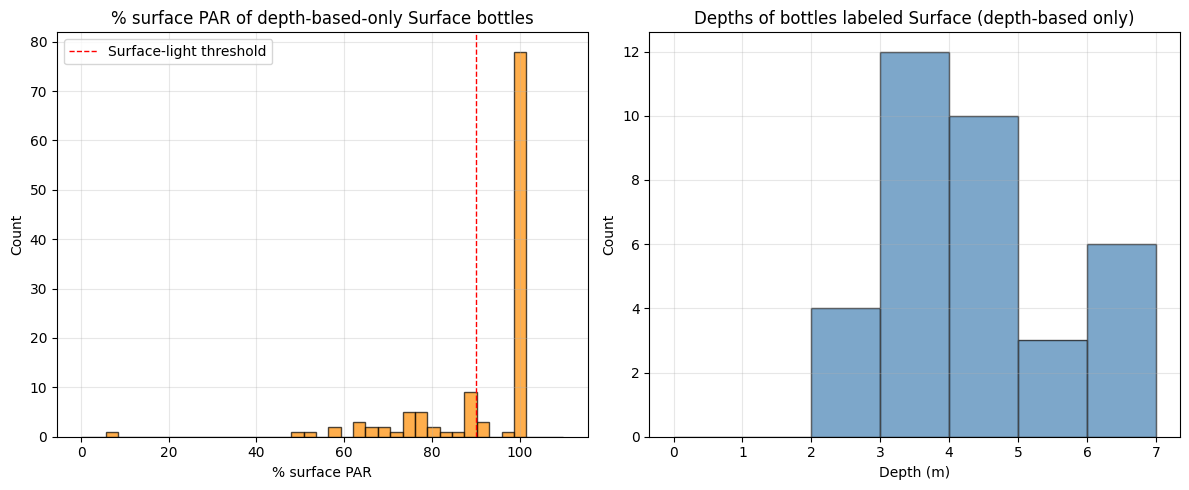

In [65]:
# Subset: Surface by depth, not by light
subset = surface_lowpar#clean_df[light_df["depth_zone_dup"].isin(["Surface", "Surface_light"])].copy()
print(f"{len(subset)} bottles labeled Surface or Surface_light by light-based classification.")


print(f"{len(subset)} bottles labeled Surface by depth-based classification only.")

# Define bins
depth_bins = np.arange(0, subset["depth_CTD"].max() + 1, 1)
par_bins   = np.linspace(0, 110, 40)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: Depth histogram ---
axes[1].hist(
    subset["depth_CTD"].dropna(),
    bins=depth_bins,
    color="steelblue",
    edgecolor="black",
    alpha=0.7
)
axes[1].set_xlabel("Depth (m)")
axes[1].set_ylabel("Count")
axes[1].set_title("Depths of bottles labeled Surface (depth-based only)")
axes[1].grid(alpha=0.3)

# --- Right: % surface PAR histogram ---
axes[0].hist(
    surface_all["Percent_surface_light"].dropna(),
    bins=par_bins,
    color="darkorange",
    edgecolor="black",
    alpha=0.7
)
axes[0].set_xlabel("% surface PAR")
axes[0].set_ylabel("Count")
axes[0].set_title("% surface PAR of depth-based-only Surface bottles")
axes[0].grid(alpha=0.3)
axes[0].axvline(90, color="red", linestyle="--", lw=1, label="Surface-light threshold")
axes[0].legend()

plt.tight_layout()
plt.show()


9 cruises have at least one questionable cast.

Plotting ae2426 (casts: [np.int64(1), np.int64(12), np.int64(15), np.int64(19), np.int64(5)])

Plotting ar28b (casts: [np.int64(12), np.int64(2), np.int64(27), np.int64(28), np.int64(3), np.int64(37), np.int64(4), np.int64(5)])

Plotting ar61b (casts: [np.int64(1), np.int64(11), np.int64(12), np.int64(18), np.int64(2), np.int64(3), np.int64(4), np.int64(6)])

Plotting en608 (casts: [np.int64(15), np.int64(9)])

Plotting en617 (casts: [np.int64(14)])

Plotting en661 (casts: [np.int64(2)])

Plotting en695 (casts: [np.int64(3), np.int64(6), np.int64(7)])

Plotting en706 (casts: [np.int64(10), np.int64(14), np.int64(15), np.int64(2), np.int64(5), np.int64(9)])

Plotting en715 (casts: [np.int64(14)])


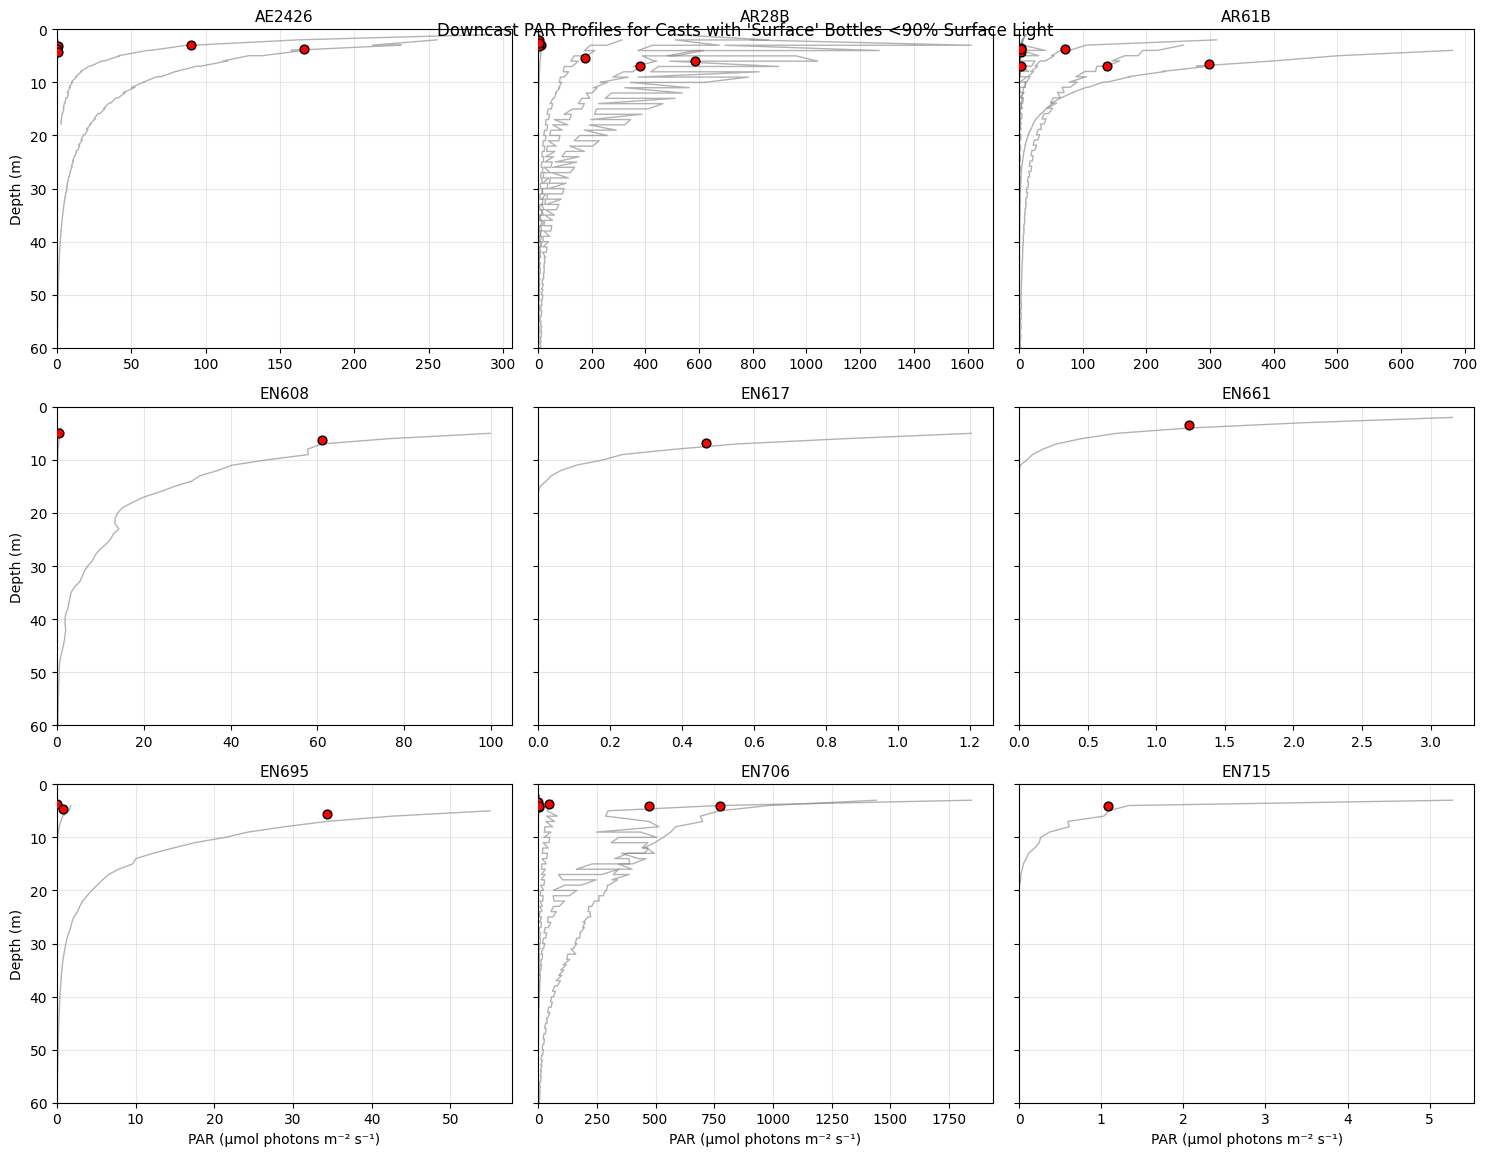

In [66]:
# --- 1. Filter questionable surface bottles (<90% surface light) ---
#questionable_surface = light_df[
#    light_df["depth_zone_light"].isin(["Surface", "Surface_light"])
#    & (light_df["Percent_surface_light"] < 90)
#].copy()

#print(f"{len(questionable_surface)} questionable 'surface' bottles (<90% surface light).")

# --- 2. Identify cruises with questionable casts ---
cruise_groups = (
    surface_lowpar.groupby("cruise")["cast"]
    .unique()
    .to_dict()
)
print(f"{len(cruise_groups)} cruises have at least one questionable cast.")

# --- 3. User-set vertical limit (in meters) ---
ylim = (0, 60)   # adjust as needed, e.g., (0, 40) or (0, 100)

# --- 4. Make 3×3 grid of subplots ---
n_cruises = len(cruise_groups)
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 12), sharey=True)
axes = axes.flatten()

# --- 5. Loop through cruises and plot ---
for i, (cruise, casts) in enumerate(cruise_groups.items()):
    if i >= nrows * ncols:
        break  # limit to 9 panels

    ax = axes[i]
    print(f"\nPlotting {cruise} (casts: {list(casts)})")

    for cast in casts:
        # Find CTD file
        match = next(
            (m for m in ctd_files
             if m["cruise"].lower() == cruise.lower()
             and m["cast"] == cast),
            None
        )
        if match is None:
            print(f"  ⚠️ No CTD file for {cruise} cast {cast}")
            continue

        # Load CTD
        df = pd.read_csv(match["path"])
        par_col = next((c for c in ["par", "cpar", "spar"] if c in df.columns), None)
        depth_col = "depsm"
        if par_col is None or depth_col not in df.columns:
            continue

        # Downcast only
        df = df.dropna(subset=[par_col, depth_col]).sort_values(by=depth_col)
        depth_diff = np.gradient(df[depth_col])
        df_down = df[depth_diff > 0].copy()

        # Plot downcast line
        ax.plot(df_down[par_col], df_down[depth_col],
                lw=1, alpha=0.6, color="gray")

        # --- Overlay questionable 'surface' bottles for this cast ---
        qs_sub = surface_lowpar[
            (surface_lowpar["cruise"].str.lower() == cruise.lower())
            & (surface_lowpar["cast"] == cast)
        ].copy()
        
        if not qs_sub.empty:
            # Plot at actual PAR values
            ax.scatter(
                qs_sub["PAR_nearest"],
                qs_sub["depth_CTD"],
                color="red",
                edgecolor="k",
                s=40,
                zorder=5,
                label="<90% surface light"
            )

    ax.set_title(cruise.upper(), fontsize=11)
    ax.invert_yaxis()
    ax.grid(alpha=0.3)
    ax.set_xlim(left=0)
    ax.set_ylim(ylim)
    ax.invert_yaxis()
    if i % ncols == 0:
        ax.set_ylabel("Depth (m)")
    if i >= (nrows - 1) * ncols:
        ax.set_xlabel("PAR (µmol photons m⁻² s⁻¹)")

# --- 6. Remove unused panels ---
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes[j])

# --- 7. Final layout ---
fig.suptitle("Downcast PAR Profiles for Casts with 'Surface' Bottles <90% Surface Light", y=0.95)
plt.tight_layout()
plt.show()


In [67]:
clean_df['depth_zone_dup'].unique()

array(['DCM_light', 'Surface', None, 'DCM', 'Surface_light'], dtype=object)

In [68]:
# --- Filter surface Niskins from clean_df ---
dcm_all = clean_df[clean_df["depth_zone_dup"].isin(["DCM", "DCM_light"])].copy()

# --- Split into two groups ---
dcm_highpar = dcm_all[dcm_all["Percent_surface_light"] > 10].copy()
dcm_clean = dcm_all[dcm_all["Percent_surface_light"] <= 10].copy()

# --- Sort dcm_clean from highest to lowest % dcm PAR ---
dcm_clean = dcm_clean.sort_values(by="Percent_surface_light", ascending=False).reset_index(drop=True)

print(f"{len(dcm_highpar)} dcm bottles have <10% dcm PAR.")
print(f"{len(dcm_clean)} dcm bottles have ≥10% dcm PAR (sorted high→low).")


18 dcm bottles have <10% dcm PAR.
101 dcm bottles have ≥10% dcm PAR (sorted high→low).


18 bottles labeled Surface or Surface_light by light-based classification.
18 bottles labeled Surface by depth-based classification only.


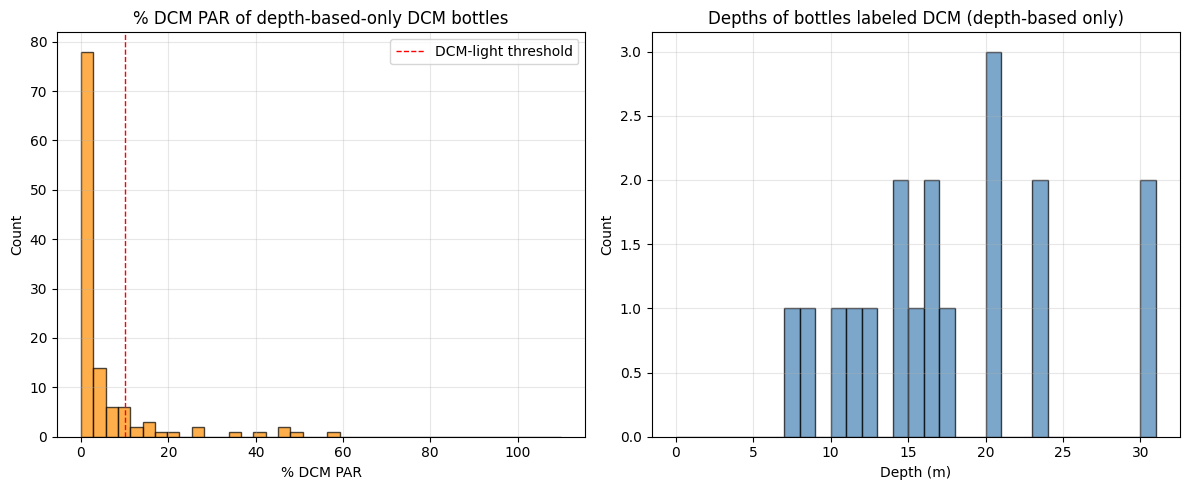

In [69]:
# Subset: Surface by depth, not by light
subset = dcm_highpar #clean_df[light_df["depth_zone_dup"].isin(["DCM", "DCM_light"])].copy()
print(f"{len(subset)} bottles labeled Surface or Surface_light by light-based classification.")


print(f"{len(subset)} bottles labeled Surface by depth-based classification only.")

# Define bins
depth_bins = np.arange(0, subset["depth_CTD"].max() + 1, 1)
par_bins   = np.linspace(0, 110, 40)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: Depth histogram ---
axes[1].hist(
    subset["depth_CTD"].dropna(),
    bins=depth_bins,
    color="steelblue",
    edgecolor="black",
    alpha=0.7
)
axes[1].set_xlabel("Depth (m)")
axes[1].set_ylabel("Count")
axes[1].set_title("Depths of bottles labeled DCM (depth-based only)")
axes[1].grid(alpha=0.3)

# --- Right: % surface PAR histogram ---
axes[0].hist(
    dcm_all["Percent_surface_light"].dropna(),
    bins=par_bins,
    color="darkorange",
    edgecolor="black",
    alpha=0.7
)
axes[0].set_xlabel("% DCM PAR")
axes[0].set_ylabel("Count")
axes[0].set_title("% DCM PAR of depth-based-only DCM bottles")
axes[0].grid(alpha=0.3)
axes[0].axvline(10, color="red", linestyle="--", lw=1, label="DCM-light threshold")
axes[0].legend()

plt.tight_layout()
plt.show()


In [70]:
dcm_highpar.columns

Index(['cruise', 'cast', 'niskin', 'depth_CTD', 'depth_zone',
       'depth_zone_method', 'PAR_nearest', 'PAR_surface',
       'Percent_surface_light', 'depth_zone_light', 'depth_zone_dup'],
      dtype='object')

9 cruises have at least one questionable cast.

Plotting ar28b (casts: [np.int64(17), np.int64(37)])

Plotting ar61b (casts: [np.int64(32), np.int64(7)])

Plotting en608 (casts: [np.int64(15)])

Plotting en617 (casts: [np.int64(1), np.int64(17), np.int64(2), np.int64(21), np.int64(9)])

Plotting en687 (casts: [np.int64(1)])

Plotting en706 (casts: [np.int64(1)])

Plotting en712 (casts: [np.int64(11), np.int64(7)])

Plotting en715 (casts: [np.int64(1), np.int64(6)])

Plotting en720 (casts: [np.int64(2), np.int64(24)])


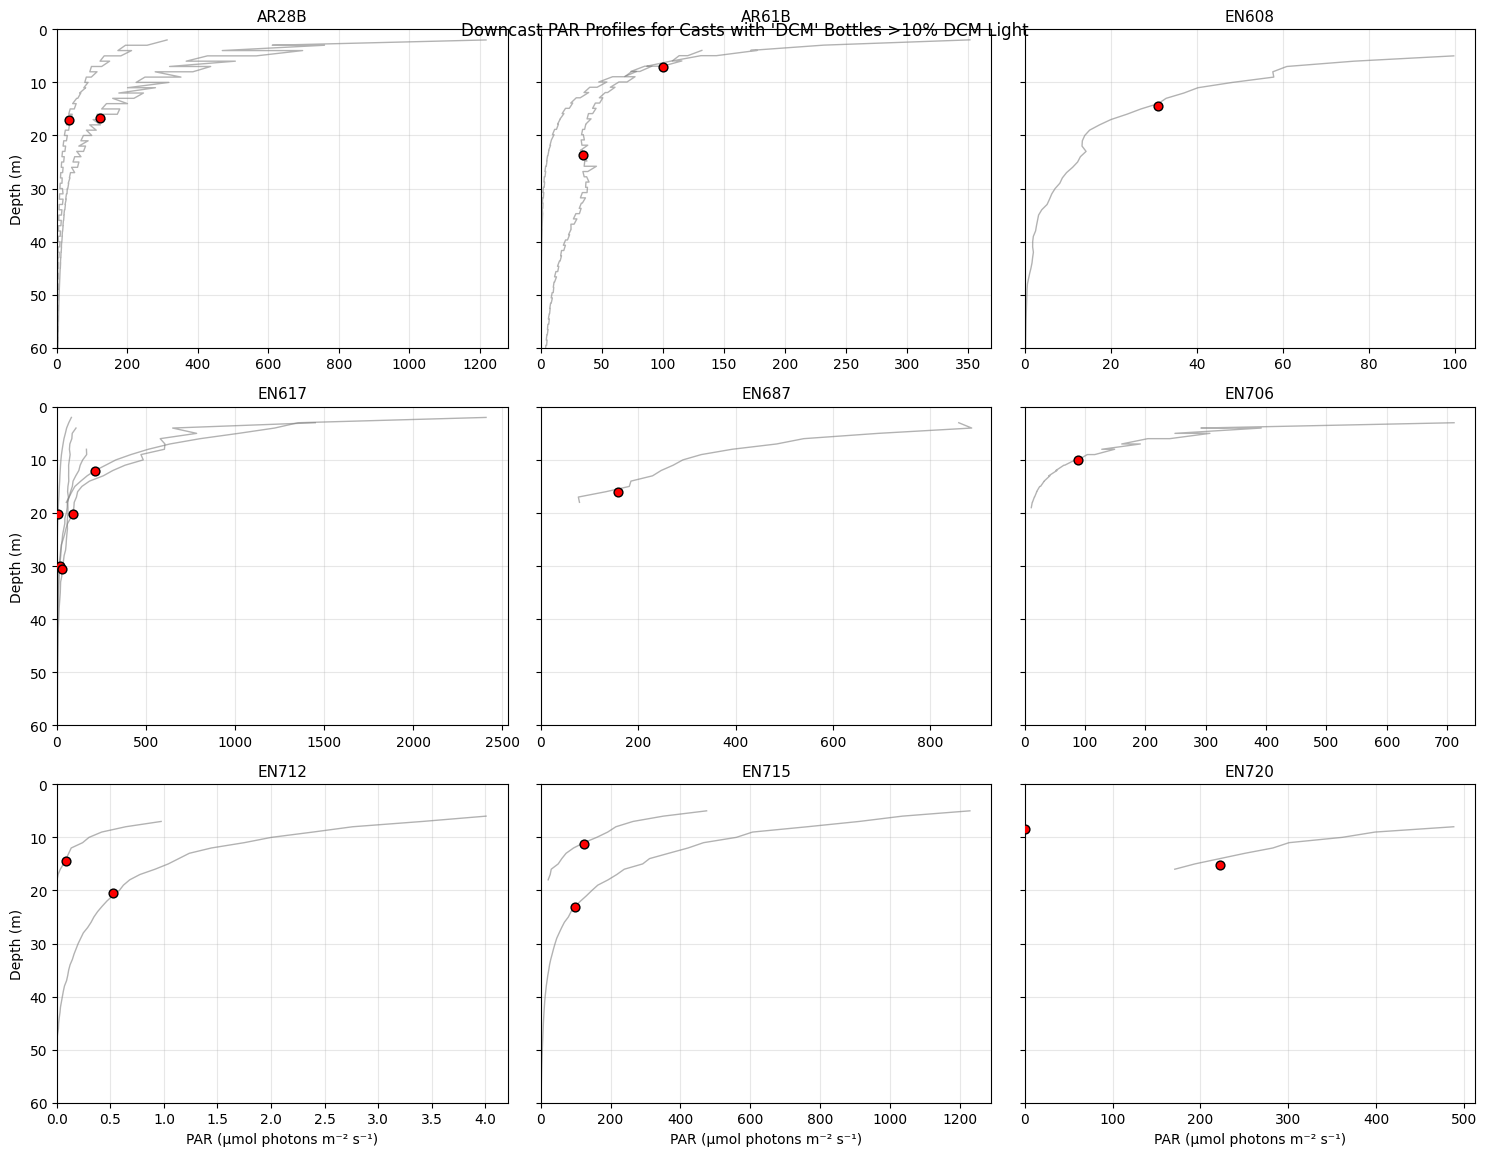

In [71]:
# --- 1. Filter questionable surface bottles (<90% surface light) ---
#questionable_dcm = dcm_all[
#    light_df["depth_zone_dup"].isin(["DCM", "DCM_light"])
#    & (light_df["Percent_surface_light"] > 10)
#].copy()

#print(f"{len(questionable_dcm)} questionable 'DCM' bottles (>10% DCM light).")

# --- 2. Identify cruises with questionable casts ---
cruise_groups = (
    dcm_highpar.groupby("cruise")["cast"]
    .unique()
    .to_dict()
)
print(f"{len(cruise_groups)} cruises have at least one questionable cast.")

# --- 3. User-set vertical limit (in meters) ---
ylim = (0, 60)   # adjust as needed, e.g., (0, 40) or (0, 100)

# --- 4. Make 3×3 grid of subplots ---
n_cruises = len(cruise_groups)
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 12), sharey=True)
axes = axes.flatten()

# --- 5. Loop through cruises and plot ---
for i, (cruise, casts) in enumerate(cruise_groups.items()):
    if i >= nrows * ncols:
        break  # limit to 9 panels

    ax = axes[i]
    print(f"\nPlotting {cruise} (casts: {list(casts)})")

    for cast in casts:
        # Find CTD file
        match = next(
            (m for m in ctd_files
             if m["cruise"].lower() == cruise.lower()
             and m["cast"] == cast),
            None
        )
        if match is None:
            print(f"  ⚠️ No CTD file for {cruise} cast {cast}")
            continue

        # Load CTD
        df = pd.read_csv(match["path"])
        par_col = next((c for c in ["par", "cpar", "spar"] if c in df.columns), None)
        depth_col = "depsm"
        if par_col is None or depth_col not in df.columns:
            continue

        # Downcast only
        df = df.dropna(subset=[par_col, depth_col]).sort_values(by=depth_col)
        depth_diff = np.gradient(df[depth_col])
        df_down = df[depth_diff > 0].copy()

        # Plot downcast line
        ax.plot(df_down[par_col], df_down[depth_col],
                lw=1, alpha=0.6, color="gray")

        # Overlay questionable bottles for this cast
        # --- Overlay questionable bottles for this cast ---
        qs_sub = dcm_highpar[
            (dcm_highpar["cruise"].str.lower() == cruise.lower())
            & (dcm_highpar["cast"] == cast)
        ].copy()
        
        if not qs_sub.empty:
            # Use actual PAR_nearest values instead of offsetting to the right
            ax.scatter(
                qs_sub["PAR_nearest"],
                qs_sub["depth_CTD"],
                color="red",
                edgecolor="k",
                s=40,
                zorder=5,
                label="High-PAR DCM"
            )


    ax.set_title(cruise.upper(), fontsize=11)
    ax.invert_yaxis()
    ax.grid(alpha=0.3)
    ax.set_xlim(left=0)
    ax.set_ylim(ylim)
    ax.invert_yaxis()
    if i % ncols == 0:
        ax.set_ylabel("Depth (m)")
    if i >= (nrows - 1) * ncols:
        ax.set_xlabel("PAR (µmol photons m⁻² s⁻¹)")

# --- 6. Remove unused panels ---
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes[j])

# --- 7. Final layout ---
fig.suptitle("Downcast PAR Profiles for Casts with 'DCM' Bottles >10% DCM Light", y=0.95)
plt.tight_layout()
plt.show()


In [72]:
dcm_highpar

,cruise,cast,niskin,depth_CTD,depth_zone,depth_zone_method,PAR_nearest,PAR_surface,Percent_surface_light,depth_zone_light,depth_zone_dup
35,ar28b,17,13,16.728007,DCM,two niskins,123.480000,697.300000,17.708303,None,DCM
45,ar28b,37,13,17.125835,DCM,two niskins,35.512000,253.555000,14.005640,None,DCM
64,ar61b,32,18,7.117771,DCM,bofu tolerance,99.861000,204.515000,48.828203,None,DCM
69,ar61b,7,17,23.757310,DCM,two niskins,34.256000,126.185000,27.147442,None,DCM
82,en608,15,15,14.387000,DCM,bofu tolerance,31.058000,68.762000,45.167389,None,DCM
102,en617,1,5,12.177000,DCM,bofu tolerance,215.330000,1288.700000,16.709087,None,DCM
112,en617,17,10,30.053000,DCM,two niskins,15.811000,155.370000,10.176353,None,DCM
117,en617,2,11,20.104000,DCM,two niskins,6.556300,60.607500,10.817638,None,DCM
120,en617,21,11,30.570000,DCM,bofu tolerance,29.147000,84.970000,34.302695,None,DCM
130,en617,9,7,20.184000,DCM,two niskins,89.469000,717.315000,12.472763,None,DCM


9 cruises have at least one questionable cast.

Plotting ar28b (casts: [np.int64(17), np.int64(37)])

Plotting ar61b (casts: [np.int64(32), np.int64(7)])

Plotting en608 (casts: [np.int64(15)])

Plotting en617 (casts: [np.int64(1), np.int64(17), np.int64(2), np.int64(21), np.int64(9)])

Plotting en687 (casts: [np.int64(1)])

Plotting en706 (casts: [np.int64(1)])

Plotting en712 (casts: [np.int64(11), np.int64(7)])

Plotting en715 (casts: [np.int64(1), np.int64(6)])

Plotting en720 (casts: [np.int64(2), np.int64(24)])


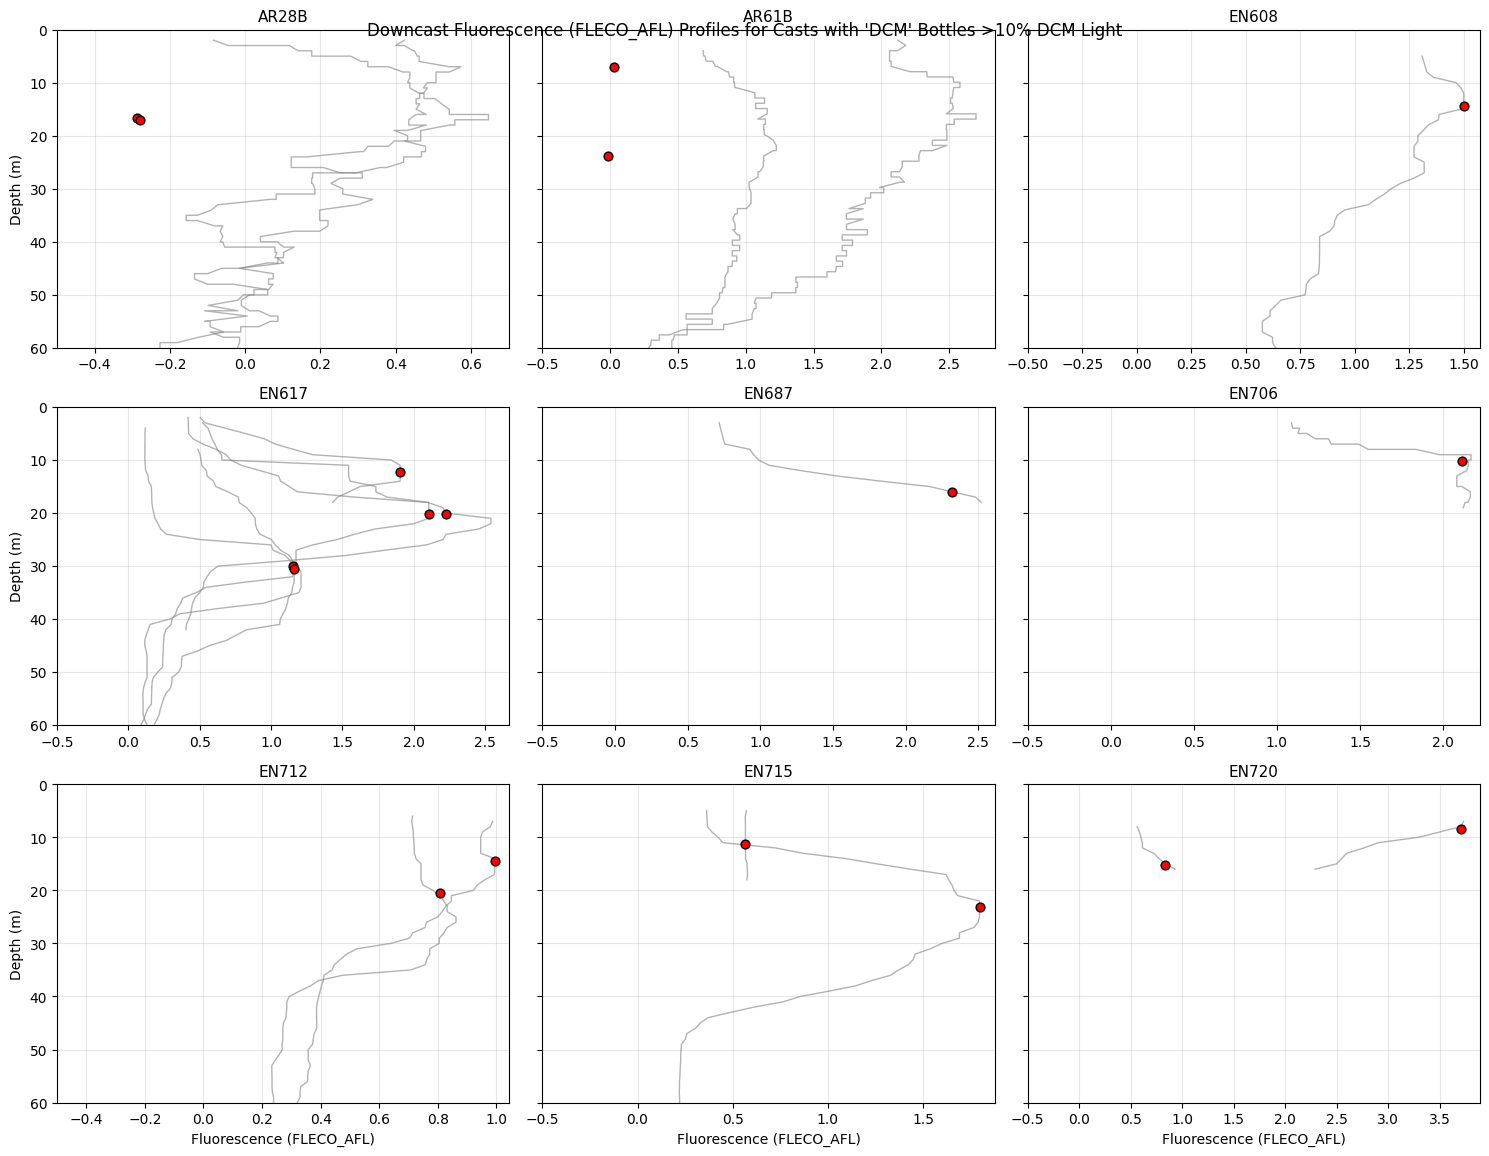

In [73]:
# --- 1. Identify cruises with questionable DCM bottles ---
cruise_groups = (
    dcm_highpar.groupby("cruise")["cast"]
    .unique()
    .to_dict()
)
print(f"{len(cruise_groups)} cruises have at least one questionable cast.")

# --- 2. User-set vertical limit ---
ylim = (0, 60)

# --- 3. Make 3×3 grid of subplots ---
n_cruises = len(cruise_groups)
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 12), sharey=True)
axes = axes.flatten()

# --- 4. Loop through cruises and plot fluorescence (fleco_afl) ---
for i, (cruise, casts) in enumerate(cruise_groups.items()):
    if i >= nrows * ncols:
        break

    ax = axes[i]
    print(f"\nPlotting {cruise} (casts: {list(casts)})")

    for cast in casts:
        # Find CTD file
        match = next(
            (m for m in ctd_files
             if m["cruise"].lower() == cruise.lower()
             and m["cast"] == cast),
            None
        )
        if match is None:
            print(f"  ⚠️ No CTD file for {cruise} cast {cast}")
            continue

        # --- Load CTD ---
        df = pd.read_csv(match["path"])
        depth_col = "depsm"
        chl_col = "fleco_afl"  # fluorescence column
        if chl_col not in df.columns or depth_col not in df.columns:
            print(f"  ⚠️ Missing fluorescence or depth column for {cruise} cast {cast}")
            continue

        # --- Extract downcast ---
        df = df.dropna(subset=[chl_col, depth_col]).sort_values(by=depth_col)
        depth_diff = np.gradient(df[depth_col])
        df_down = df[depth_diff > 0].copy()
        
        # --- Smooth fluorescence with 7-point rolling median ---
        df_down[chl_col] = df_down[chl_col].rolling(window=7, center=True, min_periods=1).median()


        # --- Plot downcast fluorescence ---
        ax.plot(df_down[chl_col], df_down[depth_col], lw=1, alpha=0.6, color="gray")

        # --- Overlay questionable bottles (DCM with high PAR) ---
        qs_sub = dcm_highpar[
            (dcm_highpar["cruise"].str.lower() == cruise.lower())
            & (dcm_highpar["cast"] == cast)
        ].copy()

        if not qs_sub.empty:
            # Plot at actual fluorescence value (FLOU_nearest) if available
            if "FLOU_nearest" in qs_sub.columns:
                xval = qs_sub["FLOU_nearest"]
            else:
                # approximate from CTD fluorescence at bottle depth
                xval = [df_down[chl_col].iloc[(df_down[depth_col] - d).abs().idxmin()]
                        for d in qs_sub["depth_CTD"]]

            ax.scatter(
                xval,
                qs_sub["depth_CTD"],
                color="red",
                edgecolor="k",
                s=40,
                zorder=5,
                label="High-FLUOR DCM"
            )

    # --- Style per panel ---
    ax.set_title(cruise.upper(), fontsize=11)
   
    ax.grid(alpha=0.3)
    ax.set_xlim(left=-0.5)
    ax.set_ylim(ylim)
    if i % ncols == 0:
        ax.set_ylabel("Depth (m)")
    if i >= (nrows - 1) * ncols:
        ax.set_xlabel("Fluorescence (FLECO_AFL)")
    ax.invert_yaxis()

# --- 5. Remove unused panels ---
for j in range(i + 1, nrows * ncols):
    fig.delaxes(axes[j])

# --- 6. Final layout ---
fig.suptitle("Downcast Fluorescence (FLECO_AFL) Profiles for Casts with 'DCM' Bottles >10% DCM Light", y=0.95)
plt.tight_layout()
plt.show()


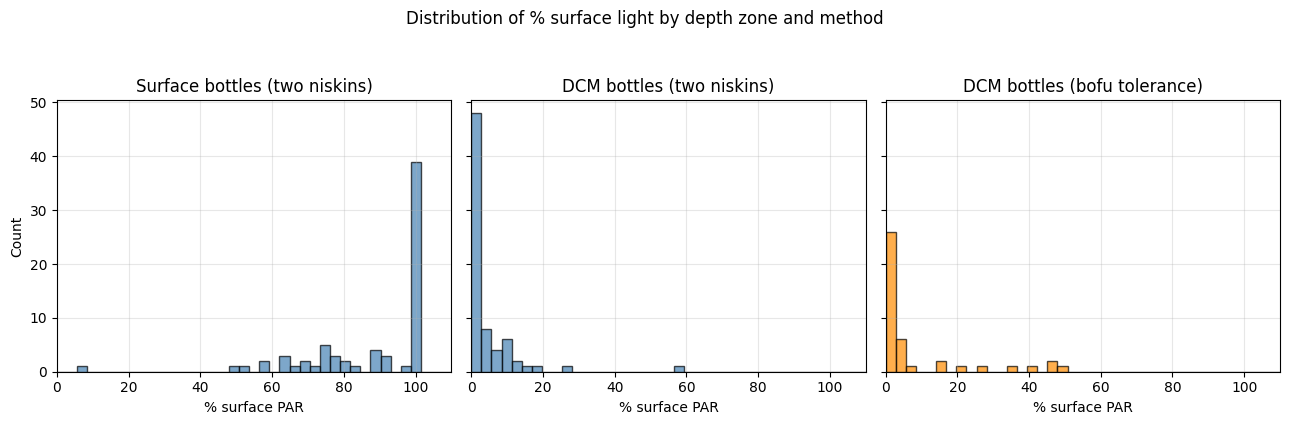

In [74]:
def plot_light_distributions_threepanel(df):
    """
    Three-panel figure of % surface light distributions:
      [1] Surface bottles — two niskins
      [2] DCM bottles — two niskins
      [3] DCM bottles — bofu tolerance
    """
    bins = np.linspace(0, 110, 40)
    colors = {"two niskins": "steelblue", "bofu tolerance": "darkorange", None: "gray"}

    fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)

    # --- Panel 1: Surface (two niskins)
    sub_surface = df[(df["depth_zone"] == "Surface") & (df["depth_zone_method"] == "two niskins")]
    if not sub_surface.empty:
        axes[0].hist(
            sub_surface["Percent_surface_light"].dropna(),
            bins=bins, color=colors["two niskins"], alpha=0.7, edgecolor="black"
        )
    axes[0].set_title("Surface bottles (two niskins)")
    axes[0].set_xlabel("% surface PAR")
    axes[0].set_ylabel("Count")
    axes[0].set_xlim(0, 110)
    axes[0].grid(alpha=0.3)

    # --- Panel 2: DCM (two niskins)
    sub_dcm_two = df[(df["depth_zone"] == "DCM") & (df["depth_zone_method"] == "two niskins")]
    if not sub_dcm_two.empty:
        axes[1].hist(
            sub_dcm_two["Percent_surface_light"].dropna(),
            bins=bins, color=colors["two niskins"], alpha=0.7, edgecolor="black"
        )
    axes[1].set_title("DCM bottles (two niskins)")
    axes[1].set_xlabel("% surface PAR")
    axes[1].set_xlim(0, 110)
    axes[1].grid(alpha=0.3)

    # --- Panel 3: DCM (bofu tolerance)
    sub_dcm_bofu = df[(df["depth_zone"] == "DCM") & (df["depth_zone_method"] == "bofu tolerance")]
    if not sub_dcm_bofu.empty:
        axes[2].hist(
            sub_dcm_bofu["Percent_surface_light"].dropna(),
            bins=bins, color=colors["bofu tolerance"], alpha=0.7, edgecolor="black"
        )
    axes[2].set_title("DCM bottles (bofu tolerance)")
    axes[2].set_xlabel("% surface PAR")
    axes[2].set_xlim(0, 110)
    axes[2].grid(alpha=0.3)

    plt.suptitle("Distribution of % surface light by depth zone and method", y=1.05)
    plt.tight_layout()
    plt.show()

df = light_df.copy()
plot_light_distributions_threepanel(clean_df)



In [75]:
def plot_surface_below_90(clean_df, ctd_files, depth_col="depsm", chl_col="fleco_afl", par_col="par"):
    """
    Plot CTD profiles for 'surface' bottles where % surface PAR < 90.
    """

    # --- Filter to surface niskins with PAR < 90 ---
    low_par = clean_df[
        clean_df["depth_zone_dup"].isin(["Surface", "Surface_light"])
        & (clean_df["Percent_surface_light"] < 90)
    ].copy()

    if low_par.empty:
        print("No surface bottles with % surface PAR < 90 found.")
        return

    casts = low_par[["cruise", "cast"]].drop_duplicates().reset_index(drop=True)
    print(f"{len(casts)} casts with surface bottles below 90% surface PAR.")

    for _, row in casts.iterrows():
        cr, ca = row["cruise"], row["cast"]

        # Match CTD file
        match = [f for f in ctd_files if f["cruise"] == cr and f["cast"] == ca]
        if not match:
            print(f"No CTD found for {cr} cast {ca}")
            continue

        try:
            ctd_df = pd.read_csv(match[0]["path"])
        except Exception as e:
            print(f"Could not read {match[0]['path']}: {e}")
            continue

        for col in [depth_col, chl_col, par_col]:
            if col in ctd_df.columns:
                ctd_df[col] = pd.to_numeric(ctd_df[col], errors="coerce")

        bottles_all = clean_df[(clean_df["cruise"] == cr) & (clean_df["cast"] == ca)]

        print(f"\nPlotting {cr} cast {ca} (surface PAR < 90%)")
        plot_ctd_with_uncat(ctd_df, bottles_all)


In [ ]:
#plot_surface_below_90(clean_df, ctd_files)

## Plot DCM greater than 10% Surface PAR

In [77]:
# --- Filter DCM niskins above 10% surface light ---
dcm_shallow = clean_df[
    clean_df["depth_zone_dup"].isin(["DCM", "DCM_light"]) &
    (clean_df["Percent_surface_light"] > 10)
].copy()

print(f"{len(dcm_shallow)} DCM bottles have >10% surface PAR.")
dcm_shallow[["cruise", "cast", "niskin", "Percent_surface_light"]]


18 DCM bottles have >10% surface PAR.


,cruise,cast,niskin,Percent_surface_light
35,ar28b,17,13,17.708303
45,ar28b,37,13,14.005640
64,ar61b,32,18,48.828203
69,ar61b,7,17,27.147442
82,en608,15,15,45.167389
102,en617,1,5,16.709087
112,en617,17,10,10.176353
117,en617,2,11,10.817638
120,en617,21,11,34.302695
130,en617,9,7,12.472763


In [ ]:
for _, row in dcm_shallow[["cruise", "cast"]].drop_duplicates().iterrows():
    cr, ca = row["cruise"], row["cast"]

    match = [f for f in ctd_files if f["cruise"] == cr and f["cast"] == ca]
    if not match:
        print(f"No CTD found for {cr} cast {ca}")
        continue

    ctd_df = pd.read_csv(match[0]["path"])
    for col in ["depsm", "fleco_afl"]:
        if col in ctd_df.columns:
            ctd_df[col] = pd.to_numeric(ctd_df[col], errors="coerce")

    bottles_all = clean_df[(clean_df["cruise"] == cr) & (clean_df["cast"] == ca)]
    print(f"Plotting {cr} cast {ca} (DCM > 10 % PAR)")
    plot_ctd_with_uncat(ctd_df, bottles_all)
